In [1]:
# Injected parameters
print_flag = False
check_memory_usage = False
time_flag = False
window_size_percentage = None
show_plots = False
reset_kernel = False
pre_configured_case = False
case_id = 7
frequency_factor = 1
frequency_factor_change_alias = True
cuda_device = 1


In [2]:
#| export
print_flag                    = None
check_memory_usage            = None
time_flag                     = None
window_size_percentage        = None
show_plots                    = None
reset_kernel                  = None
pre_configured_case           = None
case_id                       = None
frequency_factor              = None
frequency_factor_change_alias = None
check_parameters              = True
cuda_device                   = None

## Checking input parameters

In [3]:
if check_parameters:
    print("--- Check parameters ---")
    print(
        "print_flag:", print_flag,
        "check_memory_usage", check_memory_usage,
        "time_flag:", time_flag,
        "window_size_percentage:" , window_size_percentage,
        "show_plots:",show_plots,
        "reset_kernel:",reset_kernel,
        "pre_configured_case:",pre_configured_case,
        "case_id:",case_id,
        "frequency_factor:", frequency_factor, 
        "frequency_factor_change_alias", frequency_factor_change_alias,
        "cuda_device", cuda_device
)

--- Check parameters ---
print_flag: None check_memory_usage None time_flag: None window_size_percentage: None show_plots: None reset_kernel: None pre_configured_case: None case_id: None frequency_factor: None frequency_factor_change_alias None cuda_device None


## Set default input parameter values ensuring no errors
### Values explained below in their natural execution place

In [4]:
#| export
print_flag                    = True  if print_flag is None else print_flag
check_memory_usage            = True  if check_memory_usage is None else check_memory_usage
time_flag                     = True  if time_flag is None else time_flag
window_size_percentage        = False if window_size_percentage is None else window_size_percentage
show_plots                    = False if show_plots is None else show_plots
reset_kernel                  = False  if reset_kernel is None else reset_kernel
pre_configured_case           = False if pre_configured_case is None else pre_configured_case
case_id                       = 7 if case_id is None else case_id
frequency_factor              = 1 if frequency_factor is None else frequency_factor
frequency_factor_change_alias = True if frequency_factor_change_alias is None else frequency_factor_change_alias
cuda_device                   = 0 if  cuda_device is None else cuda_device

In [5]:
if check_parameters:
    print("--- Check parameters ---")
    print(
        "print_flag:", print_flag,
        "check_memory_usage", check_memory_usage,
        "time_flag:", time_flag,
        "window_size_percentage:" , window_size_percentage,
        "show_plots:",show_plots,
        "reset_kernel:",reset_kernel,
        "pre_configured_case:",pre_configured_case,
        "case_id:",case_id,
        "frequency_factor:", frequency_factor, 
        "frequency_factor_change_alias", frequency_factor_change_alias,
        "cuda_device", cuda_device
)

--- Check parameters ---
print_flag: True check_memory_usage True time_flag: True window_size_percentage: False show_plots: False reset_kernel: False pre_configured_case: False case_id: 7 frequency_factor: 1 frequency_factor_change_alias True cuda_device 0


# Encoder - MVP

> Self supervised learning Masked Value Prediction (MVP) as a way to create the embeddings.
Based on tsai's MVP

## Set-up
Initial notebook setup and specific debugging and pre-configured cases selection.
### VsCode update patch
Initial notebook setup when using VSCode.

In [6]:
#| export
# This is only needed if the notebook is run in VSCode
import sys
import dvats.utils as ut
if '--vscode' in sys.argv:
    print("Executing inside vscode")
    ut.DisplayHandle.update = ut.update_patch

### Debugging variables

- `print_flag`. If `True` it adds debbuging messages in those functions that allows so.
- `reset_kernel`. If `True` it resets the kernel by the end of the execution. Use only in case that memory management is needed.
- `check_memory_usage`. If `True`, it adds some lines for checking the GPU memmory ussage along the execution.
- `time_flag`. If `True` it get the execution time along the notebook as well as inside those functions that allows so.
- `window_size_percentage`. If `True`, MVP will be used directly with the proposed windows sizes. Otherwise, it will be asumed that they have been taken as absolute values and execution will be take that into account.
- `show_plots`. If `True` all plots are shown within the execution of the notebook. Otherwise, none of them will be plotted.

In [7]:
#| export
##### ----- This cell should be substituted by input parameters ------ #####
##### See _ploomber_engine_example_.ipynb
##### Uncomment for direct Notebook execution
#print_flag             = True
#reset_kernel           = True
#check_memory_usage     = True
#time_flag              = True
#window_size_percentage = True
#show_plots             = True

## Preconfigurated cases selection
- `pre_configured_case`. If `True`, a preconfigured case will be selected, forcing the artifact to get the expected configuration based on the information in `config\*.yml` and `utils\config.py`.
- `case_id`. If `preconfigured_case` is `True`, it forces to select the configuration of the `case_id` preconfigured samples. The available preconfigured samples are shown in the next cell.
- `frequency_factor`. If `pre_configured_case` is `True`, frequency will be resampled by `config.freq*frequency_factor`
  `frequency_factor_change_alias`. If `pre_configured_case` is `True` and `frequency_factor != 1` then the dataset alias will be modified for adding the new frequency as suffix.

In [8]:
#| export
import dvats.config as cfg_

In [9]:
#| hide
cfg_.show_available_configs()

Available datasets: 
0 - monash_australian_electricity_demand_0
1 - monash_solar_4_seconds_0
2 - wikipedia_0
3 - traffic_san_francisco_0
4 - monash_solar_10_minutes_0
5 - etth1_0
6 - stumpy_abp_0
7 - stumpy_toy_0


In [10]:
#| export 
##### ----- This cell should be substituted by input parameters ------ #####
##### See _ploomber_engine_example_.ipynb
##### Uncomment for direct Notebook execution
#pre_configured_case = False
#case_id = None
#frequency_factor = 1
#frequency_factor_change_alias = True

## Main code
### Import libraries

In [11]:
#| export
import warnings
warnings.filterwarnings("ignore", module="umap")
import os
import sys
sys.path.append(os.path.abspath('..'))
from dvats.all import *
from fastcore.all import *
from tsai.basics import *
from tsai.models.InceptionTimePlus import *
from tsai.callback.MVP import *
import matplotlib.colors as colors
from fastai.callback.wandb import WandbCallback
from fastai.callback.progress import ShowGraphCallback
from fastai.callback.schedule import *
from fastai.callback.tracker import EarlyStoppingCallback
import wandb

### Initialize and Configurate Artifact

In [12]:
#| export
wandb_api = wandb.Api()

#### Setup CUDA

In [13]:
#| export
device = torch.device(f'cuda:{cuda_device}' if torch.cuda.is_available() else 'cpu')
torch.cuda.set_device(device)
if check_memory_usage:
    gpu_device = torch.cuda.current_device()
    gpu_memory_status(gpu_device)

GPU | Used mem: 22
GPU | Used mem: 24
GPU | Memory Usage: [██████████████████--] 92%


### Get configutation from yml
> This file used the configuration files './config/base.yml' and './config/02b_encoder_MVP.ipynb'

In [14]:
#| export
user, project, version, data, config, job_type = cfg_.get_artifact_config_MVP(False)
if pre_configured_case: 
    cfg_.force_artifact_config_mvp(
        config = config,
        id = case_id,
        print_flag = print_flag, 
        both = print_flag,
        frequency_factor = frequency_factor,
        frequency_factor_change_alias = frequency_factor_change_alias
    )

### Setup Weights & biases artiffact

In [15]:
#| export
path = os.path.expanduser("~/work/nbs_pipeline/")
name="02a_encoder_MVP"
os.environ["WANDB_NOTEBOOK_NAME"] = path+name+".ipynb"
runname=name
if print_flag: print("runname: "+runname)
if print_flag: cfg_.show_attrdict(config)

runname: 02a_encoder_MVP
alias: S3
analysis_mode: online
batch_size: 512
epochs: 100
mask_future: False
mask_stateful: True
mask_sync: False
mvp_ws: (25, 50)
norm_by_sample: False
norm_use_single_batch: False
r: 0.71
stride: 9
train_artifact: mi-santamaria/deepvats/S3:latest
valid_artifact: None
use_wandb: True
valid_size: 0.2
w: 50
wandb_group: None


In [16]:
#| export
if print_flag: print("--> Wandb init")
run = wandb.init(
    entity = user,
    # work-nbs is a place to log draft runs
    project=project,
    group=config.wandb_group,
    job_type=job_type,
    allow_val_change=True,
    mode=config.analysis_mode,
    config=config,
    # When use_wandb is false the run is not linked to a personal account
    #NOTE: This is not working right now
    anonymous = 'never' if config.use_wandb else 'must', 
    resume=False,
    name = runname
)
if print_flag: print("Wandb init -->")
config = run.config  # Object for storing hyperparameters
artifacts_gettr = run.use_artifact if config.use_wandb else wandb_api.artifact


--> Wandb init
Wandb init -->


## Split data using Sliding Window & Get training artiffact

### Get W&B train artifact
Build artifact selector
Botch to use artifacts offline

In [17]:
#| export
config = run.config  # Object for storing hyperparameters
if print_flag: cfg_.show_attrdict(config)
artifacts_gettr = run.use_artifact if config.use_wandb else wandb_api.artifact
train_artifact = artifacts_gettr(config.train_artifact)
if print_flag: print("---> W&B Train Artifact")


alias: S3
analysis_mode: online
batch_size: 512
epochs: 100
mask_future: False
mask_stateful: True
mask_sync: False
mvp_ws: [25, 50]
norm_by_sample: False
norm_use_single_batch: False
r: 0.71
stride: 9
train_artifact: mi-santamaria/deepvats/S3:latest
valid_artifact: None
use_wandb: True
valid_size: 0.2
w: 50
wandb_group: None
---> W&B Train Artifact


In [18]:
#| export
df_train = train_artifact.to_df()

wandb:   1 of 1 files downloaded.  


In [19]:
#| export
if print_flag: 
    print(df_train.shape)
    display(df_train.head)
    print("df_train ~ ", df_train.shape)
    print("window_sizes = ", config.mvp_ws)
    print("wlen = ", config.w)
    df_train.head

(28800, 1)
df_train ~  (28800, 1)
window_sizes =  [25, 50]
wlen =  50


<bound method NDFrame.head of                      Seasonal time series w/ noise and trend
1970-01-01 00:00:00                               -14.877472
1970-01-01 01:00:00                               -27.750142
1970-01-01 02:00:00                               -17.186856
1970-01-01 03:00:00                               -22.882629
1970-01-01 04:00:00                               -10.478891
...                                                      ...
1973-04-14 19:00:00                                35.078186
1973-04-14 20:00:00                                32.769546
1973-04-14 21:00:00                                33.422544
1973-04-14 22:00:00                                36.557418
1973-04-14 23:00:00                                33.488992

[28800 rows x 1 columns]>

#### Get training set
Once we have build the windows, we can apply strides in order to check have the same structure as when used via sliding window

In [20]:
#| export
if print_flag: print("---> Sliding window | ", config.w,  " | ", config.stride )
sw = SlidingWindow(window_len=config.w, stride=config.stride, get_y=[])
if print_flag: print(" Sliding window | ", config.w,  " | ", config.stride, "---> | df_train ~ ", df_train.shape )
X_train, _ = sw(df_train)
if print_flag: print(" sw_df_train | ", config.w,  " | ", config.stride, "--->" )

---> Sliding window |  50  |  9
 Sliding window |  50  |  9 ---> | df_train ~  (28800, 1)
 sw_df_train |  50  |  9 --->


In [21]:
#| hide
if print_flag: 
    print(X_train.shape)

(3195, 1, 50)


### Split training set into training and test dataset

In [22]:
#| export
assert config.analysis_mode in ['offline','online'], 'Invalid analysis mode'

X = X_train
if print_flag: print("len(X): ", len(X));
if config.analysis_mode == 'online':
    if print_flag: print("--> Split 1")
    splits = TimeSplitter(valid_size=0.2, show_plot=show_plots)(X)
elif config.analysis_mode == 'offline':
    if print_flag: print("--> Split 2")
    splits = get_splits(np.arange(len(X)), valid_size=config.valid_size, show_plot = show_plots)
if print_flag: 
    print("Split -->", len(splits[0]))


len(X):  3195
--> Split 1
Split --> 2556


In [23]:
#| hide
if print_flag: 
    print(X.shape)
    display(splits)

(3195, 1, 50)


((#2556) [0,1,2,3,4,5,6,7,8,9...],
 (#639) [2556,2557,2558,2559,2560,2561,2562,2563,2564,2565...])

## MVP - Encoder training
> Train MVP with optional adaptable window sizes, to allow for inference with different
window sizes, to provide an easier exploration of the embedding space through different
ways of sliding the data.

### Set callback list

In [24]:
#| export
if print_flag: print("--> About to set callbacks")
cbs = L(WandbCallback(log_preds=False)) if config.use_wandb else L()

--> About to set callbacks


### Set transformations

In [25]:
#| export
if print_flag: print("--> About to set batch tfms")
tfms = [ToFloat(), None]
batch_tfms = [TSStandardize(by_sample=config.norm_by_sample, 
               use_single_batch=config.norm_use_single_batch)]

--> About to set batch tfms


### Get data loaders

In [26]:
#| export
dls = get_ts_dls(X, splits=splits, tfms=tfms, bs=config.batch_size, batch_tfms=batch_tfms)
if print_flag: print("get dls -->")

get dls -->


In [27]:
#| hide
if show_plots: display(dls.show_at(0))

### Build MVP TS Learner

In [28]:
#| hide
if show_plots:
    if print_flag: print("--> sgc")
    sgc = ShowGraphCallback2()
    if print_flag: print("sgc -->")
    if print_flag: print("-->learn")

In [29]:
# + tags=["skip"]
#| hide
if show_plots: 
    print("\t learn | cbs + sgc + MVP")
    learn = ts_learner(
        dls, 
        InceptionTimePlus, 
        cbs= cbs + sgc + MVP(
            r = config.r, 
            window_size=config.mvp_ws, 
            future_mask = config.mask_future, 
            target_dir='./models', 
            sync = config.mask_sync, 
            stateful = config.mask_stateful,
            fname=f'encoder_MVP'
        ), y_range=[X.min(), X.max()])
    


In [30]:
#| export
if not show_plots: #When .py this is the only option that should be available. That's why this is not an 'else' but a exported cell
    print("\t learn | cbs + MVP")
    learn = ts_learner(
        dls, 
        InceptionTimePlus, 
        cbs= cbs + MVP(
            r = config.r, 
            window_size=config.mvp_ws, 
            future_mask = config.mask_future, 
            target_dir='./models', 
            sync = config.mask_sync, 
            stateful = config.mask_stateful,
            fname=f'encoder_MVP'
        ), y_range=[X.min(), X.max()])
    
if print_flag: print("learn -->")

	 learn | cbs + MVP
learn -->


### Example mask

#### Create mask

In [31]:
#| hide
if config.mask_future:
    example_mask = create_future_mask(torch.from_numpy(X[0]), config.r, sync=config.mask_sync)
else:
    example_mask = create_subsequence_mask(torch.from_numpy(X[0]), config.r, stateful=config.mask_stateful, sync=config.mask_sync)

#### Show mask

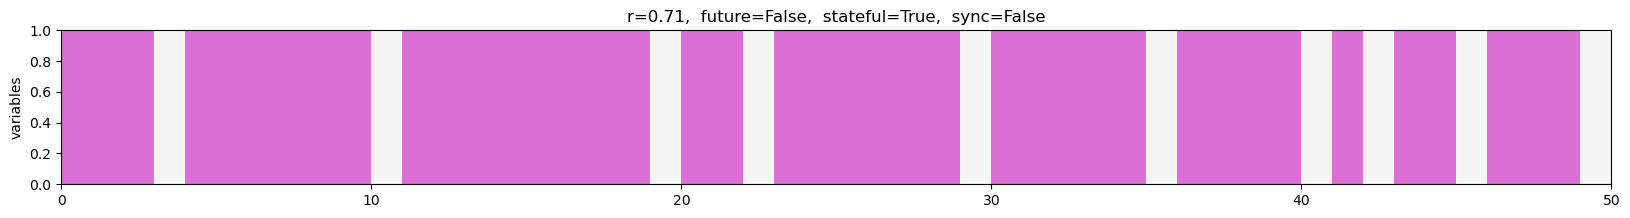

In [32]:
#| hide
fig, ax = plt.subplots(figsize=(20, 2))
plt.pcolormesh(example_mask[0], cmap=colors.ListedColormap(['whitesmoke', 'orchid']))
plt.title(f'r={config.r},  future={config.mask_future},  stateful={config.mask_stateful},  sync={config.mask_sync}')
ax.set_ylabel('variables')
plt.show()

 ## Check window size configuration

### Check config attributes

In [33]:
#| export
expected_window_size = config.mvp_ws

In [34]:
#| hide
if print_flag:
    print("w", config.w, "mvp_ws", config.mvp_ws)
    print("expected ", expected_window_size)


w 50 mvp_ws [25, 50]
expected  [25, 50]


### Check obtained attributes

In [35]:
#| export
mvp_cb = learn.cbs.filter(lambda cb: isinstance(cb, MVP))[0]  # Encuentra el callback MVP
obtained_window_size=mvp_cb.window_size

In [36]:
#| hide
if print_flag: 
    print("obtained ", obtained_window_size)

obtained  [25, 50]


In [37]:
#| export
if (expected_window_size != obtained_window_size):
    raise ValueError("Obtained window_size for MVP training different from expected window size. Check size, ws1 & ws2 parameters in '02b-encoder_MVP.yaml'")
else: 
    print("Obtained window size tuple is the expected one. Continue!")

Obtained window size tuple is the expected one. Continue!


#### Check w1 < w2 for MVP random window size selection

In [38]:
#| export
if (obtained_window_size[1] < obtained_window_size[0]):
    raise ValueError("Ws2 must be greater than Ws1 as they are the maximun and minimum window size respectively. Please ensure w2 > w1")
else: 
    w_sizes = np.random.randint(obtained_window_size)

In [39]:
# + tags=["skip"]
#| hide 
if print_flag: print(w_sizes)

[23 17]


#### Check self.x.shape[-1] for np.random.randint(0, self.x.shape[-1] - ws) MVP calculus

In [40]:
#| export
#Get data batch
x = next(iter(dls.train))
if print_flag: print("x", x)
x_data=x[0]
if print_flag: print("Data shape: " + str( x_data.shape))
time_serie_len = x_data.shape[-1]
if print_flag: print("Time serie len: " + str( time_serie_len))
#Just in case
for ws in w_sizes:
    diff = time_serie_len - ws
    if print_flag: print("diff time serie len - ws", diff)
    result = np.random.randint(0, diff)
    if print_flag: print("ws ", ws, "diff", diff, "result",  result)

x (TSTensor(samples:512, vars:1, len:50, device=cuda:0, dtype=torch.float32),)
Data shape: torch.Size([512, 1, 50])
Time serie len: 50
diff time serie len - ws 27
ws  23 diff 27 result 0
diff time serie len - ws 33
ws  17 diff 33 result 32


### Train the model

In [41]:
#| export
if print_flag: print("--> Train")
lr_valley, lr_steep = learn.lr_find(suggest_funcs=(valley, steep), show_plot=show_plots)
learn.fit_one_cycle(n_epoch=config.epochs, lr_max=lr_valley,  cbs=[EarlyStoppingCallback(monitor='valid_loss', min_delta=0.000001, patience=10)])

--> Train
No improvement since epoch 44: early stopping


epoch,train_loss,valid_loss,time


epoch,train_loss,valid_loss,time


epoch,train_loss,valid_loss,time


epoch,train_loss,valid_loss,time


epoch,train_loss,valid_loss,time


epoch,train_loss,valid_loss,time


epoch,train_loss,valid_loss,time


epoch,train_loss,valid_loss,time


epoch,train_loss,valid_loss,time
0,0.916617,4.010688,00:00


epoch,train_loss,valid_loss,time
0,0.916617,4.010688,00:00


epoch,train_loss,valid_loss,time
0,0.916617,4.010688,00:00


epoch,train_loss,valid_loss,time
0,0.916617,4.010688,00:00


epoch,train_loss,valid_loss,time
0,0.916617,4.010688,00:00


epoch,train_loss,valid_loss,time
0,0.916617,4.010688,00:00


epoch,train_loss,valid_loss,time
0,0.916617,4.010688,00:00


epoch,train_loss,valid_loss,time
0,0.916617,4.010688,00:00


epoch,train_loss,valid_loss,time
0,0.916617,4.010688,00:00
1,0.687705,4.020445,00:00


epoch,train_loss,valid_loss,time
0,0.916617,4.010688,00:00
1,0.687705,4.020445,00:00


epoch,train_loss,valid_loss,time
0,0.916617,4.010688,00:00
1,0.687705,4.020445,00:00


epoch,train_loss,valid_loss,time
0,0.916617,4.010688,00:00
1,0.687705,4.020445,00:00


epoch,train_loss,valid_loss,time
0,0.916617,4.010688,00:00
1,0.687705,4.020445,00:00


epoch,train_loss,valid_loss,time
0,0.916617,4.010688,00:00
1,0.687705,4.020445,00:00


epoch,train_loss,valid_loss,time
0,0.916617,4.010688,00:00
1,0.687705,4.020445,00:00


epoch,train_loss,valid_loss,time
0,0.916617,4.010688,00:00
1,0.687705,4.020445,00:00


epoch,train_loss,valid_loss,time
0,0.916617,4.010688,00:00
1,0.687705,4.020445,00:00
2,0.596614,3.927838,00:00


epoch,train_loss,valid_loss,time
0,0.916617,4.010688,00:00
1,0.687705,4.020445,00:00
2,0.596614,3.927838,00:00


epoch,train_loss,valid_loss,time
0,0.916617,4.010688,00:00
1,0.687705,4.020445,00:00
2,0.596614,3.927838,00:00


epoch,train_loss,valid_loss,time
0,0.916617,4.010688,00:00
1,0.687705,4.020445,00:00
2,0.596614,3.927838,00:00


epoch,train_loss,valid_loss,time
0,0.916617,4.010688,00:00
1,0.687705,4.020445,00:00
2,0.596614,3.927838,00:00


epoch,train_loss,valid_loss,time
0,0.916617,4.010688,00:00
1,0.687705,4.020445,00:00
2,0.596614,3.927838,00:00


epoch,train_loss,valid_loss,time
0,0.916617,4.010688,00:00
1,0.687705,4.020445,00:00
2,0.596614,3.927838,00:00


epoch,train_loss,valid_loss,time
0,0.916617,4.010688,00:00
1,0.687705,4.020445,00:00
2,0.596614,3.927838,00:00


epoch,train_loss,valid_loss,time
0,0.916617,4.010688,00:00
1,0.687705,4.020445,00:00
2,0.596614,3.927838,00:00
3,0.533299,3.763680,00:00


epoch,train_loss,valid_loss,time
0,0.916617,4.010688,00:00
1,0.687705,4.020445,00:00
2,0.596614,3.927838,00:00
3,0.533299,3.763680,00:00


epoch,train_loss,valid_loss,time
0,0.916617,4.010688,00:00
1,0.687705,4.020445,00:00
2,0.596614,3.927838,00:00
3,0.533299,3.763680,00:00


epoch,train_loss,valid_loss,time
0,0.916617,4.010688,00:00
1,0.687705,4.020445,00:00
2,0.596614,3.927838,00:00
3,0.533299,3.763680,00:00


epoch,train_loss,valid_loss,time
0,0.916617,4.010688,00:00
1,0.687705,4.020445,00:00
2,0.596614,3.927838,00:00
3,0.533299,3.763680,00:00


epoch,train_loss,valid_loss,time
0,0.916617,4.010688,00:00
1,0.687705,4.020445,00:00
2,0.596614,3.927838,00:00
3,0.533299,3.763680,00:00


epoch,train_loss,valid_loss,time
0,0.916617,4.010688,00:00
1,0.687705,4.020445,00:00
2,0.596614,3.927838,00:00
3,0.533299,3.763680,00:00


epoch,train_loss,valid_loss,time
0,0.916617,4.010688,00:00
1,0.687705,4.020445,00:00
2,0.596614,3.927838,00:00
3,0.533299,3.763680,00:00


epoch,train_loss,valid_loss,time
0,0.916617,4.010688,00:00
1,0.687705,4.020445,00:00
2,0.596614,3.927838,00:00
3,0.533299,3.763680,00:00
4,0.488484,3.306805,00:00


epoch,train_loss,valid_loss,time
0,0.916617,4.010688,00:00
1,0.687705,4.020445,00:00
2,0.596614,3.927838,00:00
3,0.533299,3.763680,00:00
4,0.488484,3.306805,00:00


epoch,train_loss,valid_loss,time
0,0.916617,4.010688,00:00
1,0.687705,4.020445,00:00
2,0.596614,3.927838,00:00
3,0.533299,3.763680,00:00
4,0.488484,3.306805,00:00


epoch,train_loss,valid_loss,time
0,0.916617,4.010688,00:00
1,0.687705,4.020445,00:00
2,0.596614,3.927838,00:00
3,0.533299,3.763680,00:00
4,0.488484,3.306805,00:00


epoch,train_loss,valid_loss,time
0,0.916617,4.010688,00:00
1,0.687705,4.020445,00:00
2,0.596614,3.927838,00:00
3,0.533299,3.763680,00:00
4,0.488484,3.306805,00:00


epoch,train_loss,valid_loss,time
0,0.916617,4.010688,00:00
1,0.687705,4.020445,00:00
2,0.596614,3.927838,00:00
3,0.533299,3.763680,00:00
4,0.488484,3.306805,00:00


epoch,train_loss,valid_loss,time
0,0.916617,4.010688,00:00
1,0.687705,4.020445,00:00
2,0.596614,3.927838,00:00
3,0.533299,3.763680,00:00
4,0.488484,3.306805,00:00


epoch,train_loss,valid_loss,time
0,0.916617,4.010688,00:00
1,0.687705,4.020445,00:00
2,0.596614,3.927838,00:00
3,0.533299,3.763680,00:00
4,0.488484,3.306805,00:00


epoch,train_loss,valid_loss,time
0,0.916617,4.010688,00:00
1,0.687705,4.020445,00:00
2,0.596614,3.927838,00:00
3,0.533299,3.763680,00:00
4,0.488484,3.306805,00:00
5,0.454671,2.326442,00:00


epoch,train_loss,valid_loss,time
0,0.916617,4.010688,00:00
1,0.687705,4.020445,00:00
2,0.596614,3.927838,00:00
3,0.533299,3.763680,00:00
4,0.488484,3.306805,00:00
5,0.454671,2.326442,00:00


epoch,train_loss,valid_loss,time
0,0.916617,4.010688,00:00
1,0.687705,4.020445,00:00
2,0.596614,3.927838,00:00
3,0.533299,3.763680,00:00
4,0.488484,3.306805,00:00
5,0.454671,2.326442,00:00


epoch,train_loss,valid_loss,time
0,0.916617,4.010688,00:00
1,0.687705,4.020445,00:00
2,0.596614,3.927838,00:00
3,0.533299,3.763680,00:00
4,0.488484,3.306805,00:00
5,0.454671,2.326442,00:00


epoch,train_loss,valid_loss,time
0,0.916617,4.010688,00:00
1,0.687705,4.020445,00:00
2,0.596614,3.927838,00:00
3,0.533299,3.763680,00:00
4,0.488484,3.306805,00:00
5,0.454671,2.326442,00:00


epoch,train_loss,valid_loss,time
0,0.916617,4.010688,00:00
1,0.687705,4.020445,00:00
2,0.596614,3.927838,00:00
3,0.533299,3.763680,00:00
4,0.488484,3.306805,00:00
5,0.454671,2.326442,00:00


epoch,train_loss,valid_loss,time
0,0.916617,4.010688,00:00
1,0.687705,4.020445,00:00
2,0.596614,3.927838,00:00
3,0.533299,3.763680,00:00
4,0.488484,3.306805,00:00
5,0.454671,2.326442,00:00


epoch,train_loss,valid_loss,time
0,0.916617,4.010688,00:00
1,0.687705,4.020445,00:00
2,0.596614,3.927838,00:00
3,0.533299,3.763680,00:00
4,0.488484,3.306805,00:00
5,0.454671,2.326442,00:00


epoch,train_loss,valid_loss,time
0,0.916617,4.010688,00:00
1,0.687705,4.020445,00:00
2,0.596614,3.927838,00:00
3,0.533299,3.763680,00:00
4,0.488484,3.306805,00:00
5,0.454671,2.326442,00:00
6,0.426093,1.755188,00:00


epoch,train_loss,valid_loss,time
0,0.916617,4.010688,00:00
1,0.687705,4.020445,00:00
2,0.596614,3.927838,00:00
3,0.533299,3.763680,00:00
4,0.488484,3.306805,00:00
5,0.454671,2.326442,00:00
6,0.426093,1.755188,00:00


epoch,train_loss,valid_loss,time
0,0.916617,4.010688,00:00
1,0.687705,4.020445,00:00
2,0.596614,3.927838,00:00
3,0.533299,3.763680,00:00
4,0.488484,3.306805,00:00
5,0.454671,2.326442,00:00
6,0.426093,1.755188,00:00


epoch,train_loss,valid_loss,time
0,0.916617,4.010688,00:00
1,0.687705,4.020445,00:00
2,0.596614,3.927838,00:00
3,0.533299,3.763680,00:00
4,0.488484,3.306805,00:00
5,0.454671,2.326442,00:00
6,0.426093,1.755188,00:00


epoch,train_loss,valid_loss,time
0,0.916617,4.010688,00:00
1,0.687705,4.020445,00:00
2,0.596614,3.927838,00:00
3,0.533299,3.763680,00:00
4,0.488484,3.306805,00:00
5,0.454671,2.326442,00:00
6,0.426093,1.755188,00:00


epoch,train_loss,valid_loss,time
0,0.916617,4.010688,00:00
1,0.687705,4.020445,00:00
2,0.596614,3.927838,00:00
3,0.533299,3.763680,00:00
4,0.488484,3.306805,00:00
5,0.454671,2.326442,00:00
6,0.426093,1.755188,00:00


epoch,train_loss,valid_loss,time
0,0.916617,4.010688,00:00
1,0.687705,4.020445,00:00
2,0.596614,3.927838,00:00
3,0.533299,3.763680,00:00
4,0.488484,3.306805,00:00
5,0.454671,2.326442,00:00
6,0.426093,1.755188,00:00


epoch,train_loss,valid_loss,time
0,0.916617,4.010688,00:00
1,0.687705,4.020445,00:00
2,0.596614,3.927838,00:00
3,0.533299,3.763680,00:00
4,0.488484,3.306805,00:00
5,0.454671,2.326442,00:00
6,0.426093,1.755188,00:00


epoch,train_loss,valid_loss,time
0,0.916617,4.010688,00:00
1,0.687705,4.020445,00:00
2,0.596614,3.927838,00:00
3,0.533299,3.763680,00:00
4,0.488484,3.306805,00:00
5,0.454671,2.326442,00:00
6,0.426093,1.755188,00:00
7,0.402065,1.236367,00:00


epoch,train_loss,valid_loss,time
0,0.916617,4.010688,00:00
1,0.687705,4.020445,00:00
2,0.596614,3.927838,00:00
3,0.533299,3.763680,00:00
4,0.488484,3.306805,00:00
5,0.454671,2.326442,00:00
6,0.426093,1.755188,00:00
7,0.402065,1.236367,00:00


epoch,train_loss,valid_loss,time
0,0.916617,4.010688,00:00
1,0.687705,4.020445,00:00
2,0.596614,3.927838,00:00
3,0.533299,3.763680,00:00
4,0.488484,3.306805,00:00
5,0.454671,2.326442,00:00
6,0.426093,1.755188,00:00
7,0.402065,1.236367,00:00


epoch,train_loss,valid_loss,time
0,0.916617,4.010688,00:00
1,0.687705,4.020445,00:00
2,0.596614,3.927838,00:00
3,0.533299,3.763680,00:00
4,0.488484,3.306805,00:00
5,0.454671,2.326442,00:00
6,0.426093,1.755188,00:00
7,0.402065,1.236367,00:00


epoch,train_loss,valid_loss,time
0,0.916617,4.010688,00:00
1,0.687705,4.020445,00:00
2,0.596614,3.927838,00:00
3,0.533299,3.763680,00:00
4,0.488484,3.306805,00:00
5,0.454671,2.326442,00:00
6,0.426093,1.755188,00:00
7,0.402065,1.236367,00:00


epoch,train_loss,valid_loss,time
0,0.916617,4.010688,00:00
1,0.687705,4.020445,00:00
2,0.596614,3.927838,00:00
3,0.533299,3.763680,00:00
4,0.488484,3.306805,00:00
5,0.454671,2.326442,00:00
6,0.426093,1.755188,00:00
7,0.402065,1.236367,00:00


epoch,train_loss,valid_loss,time
0,0.916617,4.010688,00:00
1,0.687705,4.020445,00:00
2,0.596614,3.927838,00:00
3,0.533299,3.763680,00:00
4,0.488484,3.306805,00:00
5,0.454671,2.326442,00:00
6,0.426093,1.755188,00:00
7,0.402065,1.236367,00:00


epoch,train_loss,valid_loss,time
0,0.916617,4.010688,00:00
1,0.687705,4.020445,00:00
2,0.596614,3.927838,00:00
3,0.533299,3.763680,00:00
4,0.488484,3.306805,00:00
5,0.454671,2.326442,00:00
6,0.426093,1.755188,00:00
7,0.402065,1.236367,00:00


epoch,train_loss,valid_loss,time
0,0.916617,4.010688,00:00
1,0.687705,4.020445,00:00
2,0.596614,3.927838,00:00
3,0.533299,3.763680,00:00
4,0.488484,3.306805,00:00
5,0.454671,2.326442,00:00
6,0.426093,1.755188,00:00
7,0.402065,1.236367,00:00
8,0.381408,0.544675,00:00


epoch,train_loss,valid_loss,time
0,0.916617,4.010688,00:00
1,0.687705,4.020445,00:00
2,0.596614,3.927838,00:00
3,0.533299,3.763680,00:00
4,0.488484,3.306805,00:00
5,0.454671,2.326442,00:00
6,0.426093,1.755188,00:00
7,0.402065,1.236367,00:00
8,0.381408,0.544675,00:00


epoch,train_loss,valid_loss,time
0,0.916617,4.010688,00:00
1,0.687705,4.020445,00:00
2,0.596614,3.927838,00:00
3,0.533299,3.763680,00:00
4,0.488484,3.306805,00:00
5,0.454671,2.326442,00:00
6,0.426093,1.755188,00:00
7,0.402065,1.236367,00:00
8,0.381408,0.544675,00:00


epoch,train_loss,valid_loss,time
0,0.916617,4.010688,00:00
1,0.687705,4.020445,00:00
2,0.596614,3.927838,00:00
3,0.533299,3.763680,00:00
4,0.488484,3.306805,00:00
5,0.454671,2.326442,00:00
6,0.426093,1.755188,00:00
7,0.402065,1.236367,00:00
8,0.381408,0.544675,00:00


epoch,train_loss,valid_loss,time
0,0.916617,4.010688,00:00
1,0.687705,4.020445,00:00
2,0.596614,3.927838,00:00
3,0.533299,3.763680,00:00
4,0.488484,3.306805,00:00
5,0.454671,2.326442,00:00
6,0.426093,1.755188,00:00
7,0.402065,1.236367,00:00
8,0.381408,0.544675,00:00


epoch,train_loss,valid_loss,time
0,0.916617,4.010688,00:00
1,0.687705,4.020445,00:00
2,0.596614,3.927838,00:00
3,0.533299,3.763680,00:00
4,0.488484,3.306805,00:00
5,0.454671,2.326442,00:00
6,0.426093,1.755188,00:00
7,0.402065,1.236367,00:00
8,0.381408,0.544675,00:00


epoch,train_loss,valid_loss,time
0,0.916617,4.010688,00:00
1,0.687705,4.020445,00:00
2,0.596614,3.927838,00:00
3,0.533299,3.763680,00:00
4,0.488484,3.306805,00:00
5,0.454671,2.326442,00:00
6,0.426093,1.755188,00:00
7,0.402065,1.236367,00:00
8,0.381408,0.544675,00:00


epoch,train_loss,valid_loss,time
0,0.916617,4.010688,00:00
1,0.687705,4.020445,00:00
2,0.596614,3.927838,00:00
3,0.533299,3.763680,00:00
4,0.488484,3.306805,00:00
5,0.454671,2.326442,00:00
6,0.426093,1.755188,00:00
7,0.402065,1.236367,00:00
8,0.381408,0.544675,00:00


epoch,train_loss,valid_loss,time
0,0.916617,4.010688,00:00
1,0.687705,4.020445,00:00
2,0.596614,3.927838,00:00
3,0.533299,3.763680,00:00
4,0.488484,3.306805,00:00
5,0.454671,2.326442,00:00
6,0.426093,1.755188,00:00
7,0.402065,1.236367,00:00
8,0.381408,0.544675,00:00
9,0.363071,1.624687,00:00


epoch,train_loss,valid_loss,time
0,0.916617,4.010688,00:00
1,0.687705,4.020445,00:00
2,0.596614,3.927838,00:00
3,0.533299,3.763680,00:00
4,0.488484,3.306805,00:00
5,0.454671,2.326442,00:00
6,0.426093,1.755188,00:00
7,0.402065,1.236367,00:00
8,0.381408,0.544675,00:00
9,0.363071,1.624687,00:00


epoch,train_loss,valid_loss,time
0,0.916617,4.010688,00:00
1,0.687705,4.020445,00:00
2,0.596614,3.927838,00:00
3,0.533299,3.763680,00:00
4,0.488484,3.306805,00:00
5,0.454671,2.326442,00:00
6,0.426093,1.755188,00:00
7,0.402065,1.236367,00:00
8,0.381408,0.544675,00:00
9,0.363071,1.624687,00:00


epoch,train_loss,valid_loss,time
0,0.916617,4.010688,00:00
1,0.687705,4.020445,00:00
2,0.596614,3.927838,00:00
3,0.533299,3.763680,00:00
4,0.488484,3.306805,00:00
5,0.454671,2.326442,00:00
6,0.426093,1.755188,00:00
7,0.402065,1.236367,00:00
8,0.381408,0.544675,00:00
9,0.363071,1.624687,00:00


epoch,train_loss,valid_loss,time
0,0.916617,4.010688,00:00
1,0.687705,4.020445,00:00
2,0.596614,3.927838,00:00
3,0.533299,3.763680,00:00
4,0.488484,3.306805,00:00
5,0.454671,2.326442,00:00
6,0.426093,1.755188,00:00
7,0.402065,1.236367,00:00
8,0.381408,0.544675,00:00
9,0.363071,1.624687,00:00


epoch,train_loss,valid_loss,time
0,0.916617,4.010688,00:00
1,0.687705,4.020445,00:00
2,0.596614,3.927838,00:00
3,0.533299,3.763680,00:00
4,0.488484,3.306805,00:00
5,0.454671,2.326442,00:00
6,0.426093,1.755188,00:00
7,0.402065,1.236367,00:00
8,0.381408,0.544675,00:00
9,0.363071,1.624687,00:00


epoch,train_loss,valid_loss,time
0,0.916617,4.010688,00:00
1,0.687705,4.020445,00:00
2,0.596614,3.927838,00:00
3,0.533299,3.763680,00:00
4,0.488484,3.306805,00:00
5,0.454671,2.326442,00:00
6,0.426093,1.755188,00:00
7,0.402065,1.236367,00:00
8,0.381408,0.544675,00:00
9,0.363071,1.624687,00:00


epoch,train_loss,valid_loss,time
0,0.916617,4.010688,00:00
1,0.687705,4.020445,00:00
2,0.596614,3.927838,00:00
3,0.533299,3.763680,00:00
4,0.488484,3.306805,00:00
5,0.454671,2.326442,00:00
6,0.426093,1.755188,00:00
7,0.402065,1.236367,00:00
8,0.381408,0.544675,00:00
9,0.363071,1.624687,00:00


epoch,train_loss,valid_loss,time
0,0.916617,4.010688,00:00
1,0.687705,4.020445,00:00
2,0.596614,3.927838,00:00
3,0.533299,3.763680,00:00
4,0.488484,3.306805,00:00
5,0.454671,2.326442,00:00
6,0.426093,1.755188,00:00
7,0.402065,1.236367,00:00
8,0.381408,0.544675,00:00
9,0.363071,1.624687,00:00


epoch,train_loss,valid_loss,time
0,0.916617,4.010688,00:00
1,0.687705,4.020445,00:00
2,0.596614,3.927838,00:00
3,0.533299,3.763680,00:00
4,0.488484,3.306805,00:00
5,0.454671,2.326442,00:00
6,0.426093,1.755188,00:00
7,0.402065,1.236367,00:00
8,0.381408,0.544675,00:00
9,0.363071,1.624687,00:00


epoch,train_loss,valid_loss,time
0,0.916617,4.010688,00:00
1,0.687705,4.020445,00:00
2,0.596614,3.927838,00:00
3,0.533299,3.763680,00:00
4,0.488484,3.306805,00:00
5,0.454671,2.326442,00:00
6,0.426093,1.755188,00:00
7,0.402065,1.236367,00:00
8,0.381408,0.544675,00:00
9,0.363071,1.624687,00:00


epoch,train_loss,valid_loss,time
0,0.916617,4.010688,00:00
1,0.687705,4.020445,00:00
2,0.596614,3.927838,00:00
3,0.533299,3.763680,00:00
4,0.488484,3.306805,00:00
5,0.454671,2.326442,00:00
6,0.426093,1.755188,00:00
7,0.402065,1.236367,00:00
8,0.381408,0.544675,00:00
9,0.363071,1.624687,00:00


epoch,train_loss,valid_loss,time
0,0.916617,4.010688,00:00
1,0.687705,4.020445,00:00
2,0.596614,3.927838,00:00
3,0.533299,3.763680,00:00
4,0.488484,3.306805,00:00
5,0.454671,2.326442,00:00
6,0.426093,1.755188,00:00
7,0.402065,1.236367,00:00
8,0.381408,0.544675,00:00
9,0.363071,1.624687,00:00


epoch,train_loss,valid_loss,time
0,0.916617,4.010688,00:00
1,0.687705,4.020445,00:00
2,0.596614,3.927838,00:00
3,0.533299,3.763680,00:00
4,0.488484,3.306805,00:00
5,0.454671,2.326442,00:00
6,0.426093,1.755188,00:00
7,0.402065,1.236367,00:00
8,0.381408,0.544675,00:00
9,0.363071,1.624687,00:00


epoch,train_loss,valid_loss,time
0,0.916617,4.010688,00:00
1,0.687705,4.020445,00:00
2,0.596614,3.927838,00:00
3,0.533299,3.763680,00:00
4,0.488484,3.306805,00:00
5,0.454671,2.326442,00:00
6,0.426093,1.755188,00:00
7,0.402065,1.236367,00:00
8,0.381408,0.544675,00:00
9,0.363071,1.624687,00:00


epoch,train_loss,valid_loss,time
0,0.916617,4.010688,00:00
1,0.687705,4.020445,00:00
2,0.596614,3.927838,00:00
3,0.533299,3.763680,00:00
4,0.488484,3.306805,00:00
5,0.454671,2.326442,00:00
6,0.426093,1.755188,00:00
7,0.402065,1.236367,00:00
8,0.381408,0.544675,00:00
9,0.363071,1.624687,00:00


epoch,train_loss,valid_loss,time
0,0.916617,4.010688,00:00
1,0.687705,4.020445,00:00
2,0.596614,3.927838,00:00
3,0.533299,3.763680,00:00
4,0.488484,3.306805,00:00
5,0.454671,2.326442,00:00
6,0.426093,1.755188,00:00
7,0.402065,1.236367,00:00
8,0.381408,0.544675,00:00
9,0.363071,1.624687,00:00


epoch,train_loss,valid_loss,time
0,0.916617,4.010688,00:00
1,0.687705,4.020445,00:00
2,0.596614,3.927838,00:00
3,0.533299,3.763680,00:00
4,0.488484,3.306805,00:00
5,0.454671,2.326442,00:00
6,0.426093,1.755188,00:00
7,0.402065,1.236367,00:00
8,0.381408,0.544675,00:00
9,0.363071,1.624687,00:00


epoch,train_loss,valid_loss,time
0,0.916617,4.010688,00:00
1,0.687705,4.020445,00:00
2,0.596614,3.927838,00:00
3,0.533299,3.763680,00:00
4,0.488484,3.306805,00:00
5,0.454671,2.326442,00:00
6,0.426093,1.755188,00:00
7,0.402065,1.236367,00:00
8,0.381408,0.544675,00:00
9,0.363071,1.624687,00:00


epoch,train_loss,valid_loss,time
0,0.916617,4.010688,00:00
1,0.687705,4.020445,00:00
2,0.596614,3.927838,00:00
3,0.533299,3.763680,00:00
4,0.488484,3.306805,00:00
5,0.454671,2.326442,00:00
6,0.426093,1.755188,00:00
7,0.402065,1.236367,00:00
8,0.381408,0.544675,00:00
9,0.363071,1.624687,00:00


epoch,train_loss,valid_loss,time
0,0.916617,4.010688,00:00
1,0.687705,4.020445,00:00
2,0.596614,3.927838,00:00
3,0.533299,3.763680,00:00
4,0.488484,3.306805,00:00
5,0.454671,2.326442,00:00
6,0.426093,1.755188,00:00
7,0.402065,1.236367,00:00
8,0.381408,0.544675,00:00
9,0.363071,1.624687,00:00


epoch,train_loss,valid_loss,time
0,0.916617,4.010688,00:00
1,0.687705,4.020445,00:00
2,0.596614,3.927838,00:00
3,0.533299,3.763680,00:00
4,0.488484,3.306805,00:00
5,0.454671,2.326442,00:00
6,0.426093,1.755188,00:00
7,0.402065,1.236367,00:00
8,0.381408,0.544675,00:00
9,0.363071,1.624687,00:00


epoch,train_loss,valid_loss,time
0,0.916617,4.010688,00:00
1,0.687705,4.020445,00:00
2,0.596614,3.927838,00:00
3,0.533299,3.763680,00:00
4,0.488484,3.306805,00:00
5,0.454671,2.326442,00:00
6,0.426093,1.755188,00:00
7,0.402065,1.236367,00:00
8,0.381408,0.544675,00:00
9,0.363071,1.624687,00:00


epoch,train_loss,valid_loss,time
0,0.916617,4.010688,00:00
1,0.687705,4.020445,00:00
2,0.596614,3.927838,00:00
3,0.533299,3.763680,00:00
4,0.488484,3.306805,00:00
5,0.454671,2.326442,00:00
6,0.426093,1.755188,00:00
7,0.402065,1.236367,00:00
8,0.381408,0.544675,00:00
9,0.363071,1.624687,00:00


epoch,train_loss,valid_loss,time
0,0.916617,4.010688,00:00
1,0.687705,4.020445,00:00
2,0.596614,3.927838,00:00
3,0.533299,3.763680,00:00
4,0.488484,3.306805,00:00
5,0.454671,2.326442,00:00
6,0.426093,1.755188,00:00
7,0.402065,1.236367,00:00
8,0.381408,0.544675,00:00
9,0.363071,1.624687,00:00


epoch,train_loss,valid_loss,time
0,0.916617,4.010688,00:00
1,0.687705,4.020445,00:00
2,0.596614,3.927838,00:00
3,0.533299,3.763680,00:00
4,0.488484,3.306805,00:00
5,0.454671,2.326442,00:00
6,0.426093,1.755188,00:00
7,0.402065,1.236367,00:00
8,0.381408,0.544675,00:00
9,0.363071,1.624687,00:00


epoch,train_loss,valid_loss,time
0,0.916617,4.010688,00:00
1,0.687705,4.020445,00:00
2,0.596614,3.927838,00:00
3,0.533299,3.763680,00:00
4,0.488484,3.306805,00:00
5,0.454671,2.326442,00:00
6,0.426093,1.755188,00:00
7,0.402065,1.236367,00:00
8,0.381408,0.544675,00:00
9,0.363071,1.624687,00:00


epoch,train_loss,valid_loss,time
0,0.916617,4.010688,00:00
1,0.687705,4.020445,00:00
2,0.596614,3.927838,00:00
3,0.533299,3.763680,00:00
4,0.488484,3.306805,00:00
5,0.454671,2.326442,00:00
6,0.426093,1.755188,00:00
7,0.402065,1.236367,00:00
8,0.381408,0.544675,00:00
9,0.363071,1.624687,00:00


epoch,train_loss,valid_loss,time
0,0.916617,4.010688,00:00
1,0.687705,4.020445,00:00
2,0.596614,3.927838,00:00
3,0.533299,3.763680,00:00
4,0.488484,3.306805,00:00
5,0.454671,2.326442,00:00
6,0.426093,1.755188,00:00
7,0.402065,1.236367,00:00
8,0.381408,0.544675,00:00
9,0.363071,1.624687,00:00


epoch,train_loss,valid_loss,time
0,0.916617,4.010688,00:00
1,0.687705,4.020445,00:00
2,0.596614,3.927838,00:00
3,0.533299,3.763680,00:00
4,0.488484,3.306805,00:00
5,0.454671,2.326442,00:00
6,0.426093,1.755188,00:00
7,0.402065,1.236367,00:00
8,0.381408,0.544675,00:00
9,0.363071,1.624687,00:00


epoch,train_loss,valid_loss,time
0,0.916617,4.010688,00:00
1,0.687705,4.020445,00:00
2,0.596614,3.927838,00:00
3,0.533299,3.763680,00:00
4,0.488484,3.306805,00:00
5,0.454671,2.326442,00:00
6,0.426093,1.755188,00:00
7,0.402065,1.236367,00:00
8,0.381408,0.544675,00:00
9,0.363071,1.624687,00:00


epoch,train_loss,valid_loss,time
0,0.916617,4.010688,00:00
1,0.687705,4.020445,00:00
2,0.596614,3.927838,00:00
3,0.533299,3.763680,00:00
4,0.488484,3.306805,00:00
5,0.454671,2.326442,00:00
6,0.426093,1.755188,00:00
7,0.402065,1.236367,00:00
8,0.381408,0.544675,00:00
9,0.363071,1.624687,00:00


epoch,train_loss,valid_loss,time
0,0.916617,4.010688,00:00
1,0.687705,4.020445,00:00
2,0.596614,3.927838,00:00
3,0.533299,3.763680,00:00
4,0.488484,3.306805,00:00
5,0.454671,2.326442,00:00
6,0.426093,1.755188,00:00
7,0.402065,1.236367,00:00
8,0.381408,0.544675,00:00
9,0.363071,1.624687,00:00


epoch,train_loss,valid_loss,time
0,0.916617,4.010688,00:00
1,0.687705,4.020445,00:00
2,0.596614,3.927838,00:00
3,0.533299,3.763680,00:00
4,0.488484,3.306805,00:00
5,0.454671,2.326442,00:00
6,0.426093,1.755188,00:00
7,0.402065,1.236367,00:00
8,0.381408,0.544675,00:00
9,0.363071,1.624687,00:00


epoch,train_loss,valid_loss,time
0,0.916617,4.010688,00:00
1,0.687705,4.020445,00:00
2,0.596614,3.927838,00:00
3,0.533299,3.763680,00:00
4,0.488484,3.306805,00:00
5,0.454671,2.326442,00:00
6,0.426093,1.755188,00:00
7,0.402065,1.236367,00:00
8,0.381408,0.544675,00:00
9,0.363071,1.624687,00:00


epoch,train_loss,valid_loss,time
0,0.916617,4.010688,00:00
1,0.687705,4.020445,00:00
2,0.596614,3.927838,00:00
3,0.533299,3.763680,00:00
4,0.488484,3.306805,00:00
5,0.454671,2.326442,00:00
6,0.426093,1.755188,00:00
7,0.402065,1.236367,00:00
8,0.381408,0.544675,00:00
9,0.363071,1.624687,00:00


epoch,train_loss,valid_loss,time
0,0.916617,4.010688,00:00
1,0.687705,4.020445,00:00
2,0.596614,3.927838,00:00
3,0.533299,3.763680,00:00
4,0.488484,3.306805,00:00
5,0.454671,2.326442,00:00
6,0.426093,1.755188,00:00
7,0.402065,1.236367,00:00
8,0.381408,0.544675,00:00
9,0.363071,1.624687,00:00


epoch,train_loss,valid_loss,time
0,0.916617,4.010688,00:00
1,0.687705,4.020445,00:00
2,0.596614,3.927838,00:00
3,0.533299,3.763680,00:00
4,0.488484,3.306805,00:00
5,0.454671,2.326442,00:00
6,0.426093,1.755188,00:00
7,0.402065,1.236367,00:00
8,0.381408,0.544675,00:00
9,0.363071,1.624687,00:00


epoch,train_loss,valid_loss,time
0,0.916617,4.010688,00:00
1,0.687705,4.020445,00:00
2,0.596614,3.927838,00:00
3,0.533299,3.763680,00:00
4,0.488484,3.306805,00:00
5,0.454671,2.326442,00:00
6,0.426093,1.755188,00:00
7,0.402065,1.236367,00:00
8,0.381408,0.544675,00:00
9,0.363071,1.624687,00:00


epoch,train_loss,valid_loss,time
0,0.916617,4.010688,00:00
1,0.687705,4.020445,00:00
2,0.596614,3.927838,00:00
3,0.533299,3.763680,00:00
4,0.488484,3.306805,00:00
5,0.454671,2.326442,00:00
6,0.426093,1.755188,00:00
7,0.402065,1.236367,00:00
8,0.381408,0.544675,00:00
9,0.363071,1.624687,00:00


epoch,train_loss,valid_loss,time
0,0.916617,4.010688,00:00
1,0.687705,4.020445,00:00
2,0.596614,3.927838,00:00
3,0.533299,3.763680,00:00
4,0.488484,3.306805,00:00
5,0.454671,2.326442,00:00
6,0.426093,1.755188,00:00
7,0.402065,1.236367,00:00
8,0.381408,0.544675,00:00
9,0.363071,1.624687,00:00


epoch,train_loss,valid_loss,time
0,0.916617,4.010688,00:00
1,0.687705,4.020445,00:00
2,0.596614,3.927838,00:00
3,0.533299,3.763680,00:00
4,0.488484,3.306805,00:00
5,0.454671,2.326442,00:00
6,0.426093,1.755188,00:00
7,0.402065,1.236367,00:00
8,0.381408,0.544675,00:00
9,0.363071,1.624687,00:00


epoch,train_loss,valid_loss,time
0,0.916617,4.010688,00:00
1,0.687705,4.020445,00:00
2,0.596614,3.927838,00:00
3,0.533299,3.763680,00:00
4,0.488484,3.306805,00:00
5,0.454671,2.326442,00:00
6,0.426093,1.755188,00:00
7,0.402065,1.236367,00:00
8,0.381408,0.544675,00:00
9,0.363071,1.624687,00:00


epoch,train_loss,valid_loss,time
0,0.916617,4.010688,00:00
1,0.687705,4.020445,00:00
2,0.596614,3.927838,00:00
3,0.533299,3.763680,00:00
4,0.488484,3.306805,00:00
5,0.454671,2.326442,00:00
6,0.426093,1.755188,00:00
7,0.402065,1.236367,00:00
8,0.381408,0.544675,00:00
9,0.363071,1.624687,00:00


epoch,train_loss,valid_loss,time
0,0.916617,4.010688,00:00
1,0.687705,4.020445,00:00
2,0.596614,3.927838,00:00
3,0.533299,3.763680,00:00
4,0.488484,3.306805,00:00
5,0.454671,2.326442,00:00
6,0.426093,1.755188,00:00
7,0.402065,1.236367,00:00
8,0.381408,0.544675,00:00
9,0.363071,1.624687,00:00


epoch,train_loss,valid_loss,time
0,0.916617,4.010688,00:00
1,0.687705,4.020445,00:00
2,0.596614,3.927838,00:00
3,0.533299,3.763680,00:00
4,0.488484,3.306805,00:00
5,0.454671,2.326442,00:00
6,0.426093,1.755188,00:00
7,0.402065,1.236367,00:00
8,0.381408,0.544675,00:00
9,0.363071,1.624687,00:00


epoch,train_loss,valid_loss,time
0,0.916617,4.010688,00:00
1,0.687705,4.020445,00:00
2,0.596614,3.927838,00:00
3,0.533299,3.763680,00:00
4,0.488484,3.306805,00:00
5,0.454671,2.326442,00:00
6,0.426093,1.755188,00:00
7,0.402065,1.236367,00:00
8,0.381408,0.544675,00:00
9,0.363071,1.624687,00:00


epoch,train_loss,valid_loss,time
0,0.916617,4.010688,00:00
1,0.687705,4.020445,00:00
2,0.596614,3.927838,00:00
3,0.533299,3.763680,00:00
4,0.488484,3.306805,00:00
5,0.454671,2.326442,00:00
6,0.426093,1.755188,00:00
7,0.402065,1.236367,00:00
8,0.381408,0.544675,00:00
9,0.363071,1.624687,00:00


epoch,train_loss,valid_loss,time
0,0.916617,4.010688,00:00
1,0.687705,4.020445,00:00
2,0.596614,3.927838,00:00
3,0.533299,3.763680,00:00
4,0.488484,3.306805,00:00
5,0.454671,2.326442,00:00
6,0.426093,1.755188,00:00
7,0.402065,1.236367,00:00
8,0.381408,0.544675,00:00
9,0.363071,1.624687,00:00


epoch,train_loss,valid_loss,time
0,0.916617,4.010688,00:00
1,0.687705,4.020445,00:00
2,0.596614,3.927838,00:00
3,0.533299,3.763680,00:00
4,0.488484,3.306805,00:00
5,0.454671,2.326442,00:00
6,0.426093,1.755188,00:00
7,0.402065,1.236367,00:00
8,0.381408,0.544675,00:00
9,0.363071,1.624687,00:00


epoch,train_loss,valid_loss,time
0,0.916617,4.010688,00:00
1,0.687705,4.020445,00:00
2,0.596614,3.927838,00:00
3,0.533299,3.763680,00:00
4,0.488484,3.306805,00:00
5,0.454671,2.326442,00:00
6,0.426093,1.755188,00:00
7,0.402065,1.236367,00:00
8,0.381408,0.544675,00:00
9,0.363071,1.624687,00:00


epoch,train_loss,valid_loss,time
0,0.916617,4.010688,00:00
1,0.687705,4.020445,00:00
2,0.596614,3.927838,00:00
3,0.533299,3.763680,00:00
4,0.488484,3.306805,00:00
5,0.454671,2.326442,00:00
6,0.426093,1.755188,00:00
7,0.402065,1.236367,00:00
8,0.381408,0.544675,00:00
9,0.363071,1.624687,00:00


epoch,train_loss,valid_loss,time
0,0.916617,4.010688,00:00
1,0.687705,4.020445,00:00
2,0.596614,3.927838,00:00
3,0.533299,3.763680,00:00
4,0.488484,3.306805,00:00
5,0.454671,2.326442,00:00
6,0.426093,1.755188,00:00
7,0.402065,1.236367,00:00
8,0.381408,0.544675,00:00
9,0.363071,1.624687,00:00


epoch,train_loss,valid_loss,time
0,0.916617,4.010688,00:00
1,0.687705,4.020445,00:00
2,0.596614,3.927838,00:00
3,0.533299,3.763680,00:00
4,0.488484,3.306805,00:00
5,0.454671,2.326442,00:00
6,0.426093,1.755188,00:00
7,0.402065,1.236367,00:00
8,0.381408,0.544675,00:00
9,0.363071,1.624687,00:00


epoch,train_loss,valid_loss,time
0,0.916617,4.010688,00:00
1,0.687705,4.020445,00:00
2,0.596614,3.927838,00:00
3,0.533299,3.763680,00:00
4,0.488484,3.306805,00:00
5,0.454671,2.326442,00:00
6,0.426093,1.755188,00:00
7,0.402065,1.236367,00:00
8,0.381408,0.544675,00:00
9,0.363071,1.624687,00:00


epoch,train_loss,valid_loss,time
0,0.916617,4.010688,00:00
1,0.687705,4.020445,00:00
2,0.596614,3.927838,00:00
3,0.533299,3.763680,00:00
4,0.488484,3.306805,00:00
5,0.454671,2.326442,00:00
6,0.426093,1.755188,00:00
7,0.402065,1.236367,00:00
8,0.381408,0.544675,00:00
9,0.363071,1.624687,00:00


epoch,train_loss,valid_loss,time
0,0.916617,4.010688,00:00
1,0.687705,4.020445,00:00
2,0.596614,3.927838,00:00
3,0.533299,3.763680,00:00
4,0.488484,3.306805,00:00
5,0.454671,2.326442,00:00
6,0.426093,1.755188,00:00
7,0.402065,1.236367,00:00
8,0.381408,0.544675,00:00
9,0.363071,1.624687,00:00


epoch,train_loss,valid_loss,time
0,0.916617,4.010688,00:00
1,0.687705,4.020445,00:00
2,0.596614,3.927838,00:00
3,0.533299,3.763680,00:00
4,0.488484,3.306805,00:00
5,0.454671,2.326442,00:00
6,0.426093,1.755188,00:00
7,0.402065,1.236367,00:00
8,0.381408,0.544675,00:00
9,0.363071,1.624687,00:00


epoch,train_loss,valid_loss,time
0,0.916617,4.010688,00:00
1,0.687705,4.020445,00:00
2,0.596614,3.927838,00:00
3,0.533299,3.763680,00:00
4,0.488484,3.306805,00:00
5,0.454671,2.326442,00:00
6,0.426093,1.755188,00:00
7,0.402065,1.236367,00:00
8,0.381408,0.544675,00:00
9,0.363071,1.624687,00:00


epoch,train_loss,valid_loss,time
0,0.916617,4.010688,00:00
1,0.687705,4.020445,00:00
2,0.596614,3.927838,00:00
3,0.533299,3.763680,00:00
4,0.488484,3.306805,00:00
5,0.454671,2.326442,00:00
6,0.426093,1.755188,00:00
7,0.402065,1.236367,00:00
8,0.381408,0.544675,00:00
9,0.363071,1.624687,00:00


epoch,train_loss,valid_loss,time
0,0.916617,4.010688,00:00
1,0.687705,4.020445,00:00
2,0.596614,3.927838,00:00
3,0.533299,3.763680,00:00
4,0.488484,3.306805,00:00
5,0.454671,2.326442,00:00
6,0.426093,1.755188,00:00
7,0.402065,1.236367,00:00
8,0.381408,0.544675,00:00
9,0.363071,1.624687,00:00


epoch,train_loss,valid_loss,time
0,0.916617,4.010688,00:00
1,0.687705,4.020445,00:00
2,0.596614,3.927838,00:00
3,0.533299,3.763680,00:00
4,0.488484,3.306805,00:00
5,0.454671,2.326442,00:00
6,0.426093,1.755188,00:00
7,0.402065,1.236367,00:00
8,0.381408,0.544675,00:00
9,0.363071,1.624687,00:00


epoch,train_loss,valid_loss,time
0,0.916617,4.010688,00:00
1,0.687705,4.020445,00:00
2,0.596614,3.927838,00:00
3,0.533299,3.763680,00:00
4,0.488484,3.306805,00:00
5,0.454671,2.326442,00:00
6,0.426093,1.755188,00:00
7,0.402065,1.236367,00:00
8,0.381408,0.544675,00:00
9,0.363071,1.624687,00:00


epoch,train_loss,valid_loss,time
0,0.916617,4.010688,00:00
1,0.687705,4.020445,00:00
2,0.596614,3.927838,00:00
3,0.533299,3.763680,00:00
4,0.488484,3.306805,00:00
5,0.454671,2.326442,00:00
6,0.426093,1.755188,00:00
7,0.402065,1.236367,00:00
8,0.381408,0.544675,00:00
9,0.363071,1.624687,00:00


epoch,train_loss,valid_loss,time
0,0.916617,4.010688,00:00
1,0.687705,4.020445,00:00
2,0.596614,3.927838,00:00
3,0.533299,3.763680,00:00
4,0.488484,3.306805,00:00
5,0.454671,2.326442,00:00
6,0.426093,1.755188,00:00
7,0.402065,1.236367,00:00
8,0.381408,0.544675,00:00
9,0.363071,1.624687,00:00


epoch,train_loss,valid_loss,time
0,0.916617,4.010688,00:00
1,0.687705,4.020445,00:00
2,0.596614,3.927838,00:00
3,0.533299,3.763680,00:00
4,0.488484,3.306805,00:00
5,0.454671,2.326442,00:00
6,0.426093,1.755188,00:00
7,0.402065,1.236367,00:00
8,0.381408,0.544675,00:00
9,0.363071,1.624687,00:00


epoch,train_loss,valid_loss,time
0,0.916617,4.010688,00:00
1,0.687705,4.020445,00:00
2,0.596614,3.927838,00:00
3,0.533299,3.763680,00:00
4,0.488484,3.306805,00:00
5,0.454671,2.326442,00:00
6,0.426093,1.755188,00:00
7,0.402065,1.236367,00:00
8,0.381408,0.544675,00:00
9,0.363071,1.624687,00:00


epoch,train_loss,valid_loss,time
0,0.916617,4.010688,00:00
1,0.687705,4.020445,00:00
2,0.596614,3.927838,00:00
3,0.533299,3.763680,00:00
4,0.488484,3.306805,00:00
5,0.454671,2.326442,00:00
6,0.426093,1.755188,00:00
7,0.402065,1.236367,00:00
8,0.381408,0.544675,00:00
9,0.363071,1.624687,00:00


epoch,train_loss,valid_loss,time
0,0.916617,4.010688,00:00
1,0.687705,4.020445,00:00
2,0.596614,3.927838,00:00
3,0.533299,3.763680,00:00
4,0.488484,3.306805,00:00
5,0.454671,2.326442,00:00
6,0.426093,1.755188,00:00
7,0.402065,1.236367,00:00
8,0.381408,0.544675,00:00
9,0.363071,1.624687,00:00


epoch,train_loss,valid_loss,time
0,0.916617,4.010688,00:00
1,0.687705,4.020445,00:00
2,0.596614,3.927838,00:00
3,0.533299,3.763680,00:00
4,0.488484,3.306805,00:00
5,0.454671,2.326442,00:00
6,0.426093,1.755188,00:00
7,0.402065,1.236367,00:00
8,0.381408,0.544675,00:00
9,0.363071,1.624687,00:00


epoch,train_loss,valid_loss,time
0,0.916617,4.010688,00:00
1,0.687705,4.020445,00:00
2,0.596614,3.927838,00:00
3,0.533299,3.763680,00:00
4,0.488484,3.306805,00:00
5,0.454671,2.326442,00:00
6,0.426093,1.755188,00:00
7,0.402065,1.236367,00:00
8,0.381408,0.544675,00:00
9,0.363071,1.624687,00:00


epoch,train_loss,valid_loss,time
0,0.916617,4.010688,00:00
1,0.687705,4.020445,00:00
2,0.596614,3.927838,00:00
3,0.533299,3.763680,00:00
4,0.488484,3.306805,00:00
5,0.454671,2.326442,00:00
6,0.426093,1.755188,00:00
7,0.402065,1.236367,00:00
8,0.381408,0.544675,00:00
9,0.363071,1.624687,00:00


epoch,train_loss,valid_loss,time
0,0.916617,4.010688,00:00
1,0.687705,4.020445,00:00
2,0.596614,3.927838,00:00
3,0.533299,3.763680,00:00
4,0.488484,3.306805,00:00
5,0.454671,2.326442,00:00
6,0.426093,1.755188,00:00
7,0.402065,1.236367,00:00
8,0.381408,0.544675,00:00
9,0.363071,1.624687,00:00


epoch,train_loss,valid_loss,time
0,0.916617,4.010688,00:00
1,0.687705,4.020445,00:00
2,0.596614,3.927838,00:00
3,0.533299,3.763680,00:00
4,0.488484,3.306805,00:00
5,0.454671,2.326442,00:00
6,0.426093,1.755188,00:00
7,0.402065,1.236367,00:00
8,0.381408,0.544675,00:00
9,0.363071,1.624687,00:00


epoch,train_loss,valid_loss,time
0,0.916617,4.010688,00:00
1,0.687705,4.020445,00:00
2,0.596614,3.927838,00:00
3,0.533299,3.763680,00:00
4,0.488484,3.306805,00:00
5,0.454671,2.326442,00:00
6,0.426093,1.755188,00:00
7,0.402065,1.236367,00:00
8,0.381408,0.544675,00:00
9,0.363071,1.624687,00:00


epoch,train_loss,valid_loss,time
0,0.916617,4.010688,00:00
1,0.687705,4.020445,00:00
2,0.596614,3.927838,00:00
3,0.533299,3.763680,00:00
4,0.488484,3.306805,00:00
5,0.454671,2.326442,00:00
6,0.426093,1.755188,00:00
7,0.402065,1.236367,00:00
8,0.381408,0.544675,00:00
9,0.363071,1.624687,00:00


epoch,train_loss,valid_loss,time
0,0.916617,4.010688,00:00
1,0.687705,4.020445,00:00
2,0.596614,3.927838,00:00
3,0.533299,3.763680,00:00
4,0.488484,3.306805,00:00
5,0.454671,2.326442,00:00
6,0.426093,1.755188,00:00
7,0.402065,1.236367,00:00
8,0.381408,0.544675,00:00
9,0.363071,1.624687,00:00


epoch,train_loss,valid_loss,time
0,0.916617,4.010688,00:00
1,0.687705,4.020445,00:00
2,0.596614,3.927838,00:00
3,0.533299,3.763680,00:00
4,0.488484,3.306805,00:00
5,0.454671,2.326442,00:00
6,0.426093,1.755188,00:00
7,0.402065,1.236367,00:00
8,0.381408,0.544675,00:00
9,0.363071,1.624687,00:00


epoch,train_loss,valid_loss,time
0,0.916617,4.010688,00:00
1,0.687705,4.020445,00:00
2,0.596614,3.927838,00:00
3,0.533299,3.763680,00:00
4,0.488484,3.306805,00:00
5,0.454671,2.326442,00:00
6,0.426093,1.755188,00:00
7,0.402065,1.236367,00:00
8,0.381408,0.544675,00:00
9,0.363071,1.624687,00:00


epoch,train_loss,valid_loss,time
0,0.916617,4.010688,00:00
1,0.687705,4.020445,00:00
2,0.596614,3.927838,00:00
3,0.533299,3.763680,00:00
4,0.488484,3.306805,00:00
5,0.454671,2.326442,00:00
6,0.426093,1.755188,00:00
7,0.402065,1.236367,00:00
8,0.381408,0.544675,00:00
9,0.363071,1.624687,00:00


epoch,train_loss,valid_loss,time
0,0.916617,4.010688,00:00
1,0.687705,4.020445,00:00
2,0.596614,3.927838,00:00
3,0.533299,3.763680,00:00
4,0.488484,3.306805,00:00
5,0.454671,2.326442,00:00
6,0.426093,1.755188,00:00
7,0.402065,1.236367,00:00
8,0.381408,0.544675,00:00
9,0.363071,1.624687,00:00


epoch,train_loss,valid_loss,time
0,0.916617,4.010688,00:00
1,0.687705,4.020445,00:00
2,0.596614,3.927838,00:00
3,0.533299,3.763680,00:00
4,0.488484,3.306805,00:00
5,0.454671,2.326442,00:00
6,0.426093,1.755188,00:00
7,0.402065,1.236367,00:00
8,0.381408,0.544675,00:00
9,0.363071,1.624687,00:00


epoch,train_loss,valid_loss,time
0,0.916617,4.010688,00:00
1,0.687705,4.020445,00:00
2,0.596614,3.927838,00:00
3,0.533299,3.763680,00:00
4,0.488484,3.306805,00:00
5,0.454671,2.326442,00:00
6,0.426093,1.755188,00:00
7,0.402065,1.236367,00:00
8,0.381408,0.544675,00:00
9,0.363071,1.624687,00:00


epoch,train_loss,valid_loss,time
0,0.916617,4.010688,00:00
1,0.687705,4.020445,00:00
2,0.596614,3.927838,00:00
3,0.533299,3.763680,00:00
4,0.488484,3.306805,00:00
5,0.454671,2.326442,00:00
6,0.426093,1.755188,00:00
7,0.402065,1.236367,00:00
8,0.381408,0.544675,00:00
9,0.363071,1.624687,00:00


epoch,train_loss,valid_loss,time
0,0.916617,4.010688,00:00
1,0.687705,4.020445,00:00
2,0.596614,3.927838,00:00
3,0.533299,3.763680,00:00
4,0.488484,3.306805,00:00
5,0.454671,2.326442,00:00
6,0.426093,1.755188,00:00
7,0.402065,1.236367,00:00
8,0.381408,0.544675,00:00
9,0.363071,1.624687,00:00


epoch,train_loss,valid_loss,time
0,0.916617,4.010688,00:00
1,0.687705,4.020445,00:00
2,0.596614,3.927838,00:00
3,0.533299,3.763680,00:00
4,0.488484,3.306805,00:00
5,0.454671,2.326442,00:00
6,0.426093,1.755188,00:00
7,0.402065,1.236367,00:00
8,0.381408,0.544675,00:00
9,0.363071,1.624687,00:00


epoch,train_loss,valid_loss,time
0,0.916617,4.010688,00:00
1,0.687705,4.020445,00:00
2,0.596614,3.927838,00:00
3,0.533299,3.763680,00:00
4,0.488484,3.306805,00:00
5,0.454671,2.326442,00:00
6,0.426093,1.755188,00:00
7,0.402065,1.236367,00:00
8,0.381408,0.544675,00:00
9,0.363071,1.624687,00:00


epoch,train_loss,valid_loss,time
0,0.916617,4.010688,00:00
1,0.687705,4.020445,00:00
2,0.596614,3.927838,00:00
3,0.533299,3.763680,00:00
4,0.488484,3.306805,00:00
5,0.454671,2.326442,00:00
6,0.426093,1.755188,00:00
7,0.402065,1.236367,00:00
8,0.381408,0.544675,00:00
9,0.363071,1.624687,00:00


epoch,train_loss,valid_loss,time
0,0.916617,4.010688,00:00
1,0.687705,4.020445,00:00
2,0.596614,3.927838,00:00
3,0.533299,3.763680,00:00
4,0.488484,3.306805,00:00
5,0.454671,2.326442,00:00
6,0.426093,1.755188,00:00
7,0.402065,1.236367,00:00
8,0.381408,0.544675,00:00
9,0.363071,1.624687,00:00


epoch,train_loss,valid_loss,time
0,0.916617,4.010688,00:00
1,0.687705,4.020445,00:00
2,0.596614,3.927838,00:00
3,0.533299,3.763680,00:00
4,0.488484,3.306805,00:00
5,0.454671,2.326442,00:00
6,0.426093,1.755188,00:00
7,0.402065,1.236367,00:00
8,0.381408,0.544675,00:00
9,0.363071,1.624687,00:00


epoch,train_loss,valid_loss,time
0,0.916617,4.010688,00:00
1,0.687705,4.020445,00:00
2,0.596614,3.927838,00:00
3,0.533299,3.763680,00:00
4,0.488484,3.306805,00:00
5,0.454671,2.326442,00:00
6,0.426093,1.755188,00:00
7,0.402065,1.236367,00:00
8,0.381408,0.544675,00:00
9,0.363071,1.624687,00:00


epoch,train_loss,valid_loss,time
0,0.916617,4.010688,00:00
1,0.687705,4.020445,00:00
2,0.596614,3.927838,00:00
3,0.533299,3.763680,00:00
4,0.488484,3.306805,00:00
5,0.454671,2.326442,00:00
6,0.426093,1.755188,00:00
7,0.402065,1.236367,00:00
8,0.381408,0.544675,00:00
9,0.363071,1.624687,00:00


epoch,train_loss,valid_loss,time
0,0.916617,4.010688,00:00
1,0.687705,4.020445,00:00
2,0.596614,3.927838,00:00
3,0.533299,3.763680,00:00
4,0.488484,3.306805,00:00
5,0.454671,2.326442,00:00
6,0.426093,1.755188,00:00
7,0.402065,1.236367,00:00
8,0.381408,0.544675,00:00
9,0.363071,1.624687,00:00


epoch,train_loss,valid_loss,time
0,0.916617,4.010688,00:00
1,0.687705,4.020445,00:00
2,0.596614,3.927838,00:00
3,0.533299,3.763680,00:00
4,0.488484,3.306805,00:00
5,0.454671,2.326442,00:00
6,0.426093,1.755188,00:00
7,0.402065,1.236367,00:00
8,0.381408,0.544675,00:00
9,0.363071,1.624687,00:00


epoch,train_loss,valid_loss,time
0,0.916617,4.010688,00:00
1,0.687705,4.020445,00:00
2,0.596614,3.927838,00:00
3,0.533299,3.763680,00:00
4,0.488484,3.306805,00:00
5,0.454671,2.326442,00:00
6,0.426093,1.755188,00:00
7,0.402065,1.236367,00:00
8,0.381408,0.544675,00:00
9,0.363071,1.624687,00:00


epoch,train_loss,valid_loss,time
0,0.916617,4.010688,00:00
1,0.687705,4.020445,00:00
2,0.596614,3.927838,00:00
3,0.533299,3.763680,00:00
4,0.488484,3.306805,00:00
5,0.454671,2.326442,00:00
6,0.426093,1.755188,00:00
7,0.402065,1.236367,00:00
8,0.381408,0.544675,00:00
9,0.363071,1.624687,00:00


epoch,train_loss,valid_loss,time
0,0.916617,4.010688,00:00
1,0.687705,4.020445,00:00
2,0.596614,3.927838,00:00
3,0.533299,3.763680,00:00
4,0.488484,3.306805,00:00
5,0.454671,2.326442,00:00
6,0.426093,1.755188,00:00
7,0.402065,1.236367,00:00
8,0.381408,0.544675,00:00
9,0.363071,1.624687,00:00


epoch,train_loss,valid_loss,time
0,0.916617,4.010688,00:00
1,0.687705,4.020445,00:00
2,0.596614,3.927838,00:00
3,0.533299,3.763680,00:00
4,0.488484,3.306805,00:00
5,0.454671,2.326442,00:00
6,0.426093,1.755188,00:00
7,0.402065,1.236367,00:00
8,0.381408,0.544675,00:00
9,0.363071,1.624687,00:00


epoch,train_loss,valid_loss,time
0,0.916617,4.010688,00:00
1,0.687705,4.020445,00:00
2,0.596614,3.927838,00:00
3,0.533299,3.763680,00:00
4,0.488484,3.306805,00:00
5,0.454671,2.326442,00:00
6,0.426093,1.755188,00:00
7,0.402065,1.236367,00:00
8,0.381408,0.544675,00:00
9,0.363071,1.624687,00:00


epoch,train_loss,valid_loss,time
0,0.916617,4.010688,00:00
1,0.687705,4.020445,00:00
2,0.596614,3.927838,00:00
3,0.533299,3.763680,00:00
4,0.488484,3.306805,00:00
5,0.454671,2.326442,00:00
6,0.426093,1.755188,00:00
7,0.402065,1.236367,00:00
8,0.381408,0.544675,00:00
9,0.363071,1.624687,00:00


epoch,train_loss,valid_loss,time
0,0.916617,4.010688,00:00
1,0.687705,4.020445,00:00
2,0.596614,3.927838,00:00
3,0.533299,3.763680,00:00
4,0.488484,3.306805,00:00
5,0.454671,2.326442,00:00
6,0.426093,1.755188,00:00
7,0.402065,1.236367,00:00
8,0.381408,0.544675,00:00
9,0.363071,1.624687,00:00


epoch,train_loss,valid_loss,time
0,0.916617,4.010688,00:00
1,0.687705,4.020445,00:00
2,0.596614,3.927838,00:00
3,0.533299,3.763680,00:00
4,0.488484,3.306805,00:00
5,0.454671,2.326442,00:00
6,0.426093,1.755188,00:00
7,0.402065,1.236367,00:00
8,0.381408,0.544675,00:00
9,0.363071,1.624687,00:00


epoch,train_loss,valid_loss,time
0,0.916617,4.010688,00:00
1,0.687705,4.020445,00:00
2,0.596614,3.927838,00:00
3,0.533299,3.763680,00:00
4,0.488484,3.306805,00:00
5,0.454671,2.326442,00:00
6,0.426093,1.755188,00:00
7,0.402065,1.236367,00:00
8,0.381408,0.544675,00:00
9,0.363071,1.624687,00:00


epoch,train_loss,valid_loss,time
0,0.916617,4.010688,00:00
1,0.687705,4.020445,00:00
2,0.596614,3.927838,00:00
3,0.533299,3.763680,00:00
4,0.488484,3.306805,00:00
5,0.454671,2.326442,00:00
6,0.426093,1.755188,00:00
7,0.402065,1.236367,00:00
8,0.381408,0.544675,00:00
9,0.363071,1.624687,00:00


epoch,train_loss,valid_loss,time
0,0.916617,4.010688,00:00
1,0.687705,4.020445,00:00
2,0.596614,3.927838,00:00
3,0.533299,3.763680,00:00
4,0.488484,3.306805,00:00
5,0.454671,2.326442,00:00
6,0.426093,1.755188,00:00
7,0.402065,1.236367,00:00
8,0.381408,0.544675,00:00
9,0.363071,1.624687,00:00


epoch,train_loss,valid_loss,time
0,0.916617,4.010688,00:00
1,0.687705,4.020445,00:00
2,0.596614,3.927838,00:00
3,0.533299,3.763680,00:00
4,0.488484,3.306805,00:00
5,0.454671,2.326442,00:00
6,0.426093,1.755188,00:00
7,0.402065,1.236367,00:00
8,0.381408,0.544675,00:00
9,0.363071,1.624687,00:00


epoch,train_loss,valid_loss,time
0,0.916617,4.010688,00:00
1,0.687705,4.020445,00:00
2,0.596614,3.927838,00:00
3,0.533299,3.763680,00:00
4,0.488484,3.306805,00:00
5,0.454671,2.326442,00:00
6,0.426093,1.755188,00:00
7,0.402065,1.236367,00:00
8,0.381408,0.544675,00:00
9,0.363071,1.624687,00:00


epoch,train_loss,valid_loss,time
0,0.916617,4.010688,00:00
1,0.687705,4.020445,00:00
2,0.596614,3.927838,00:00
3,0.533299,3.763680,00:00
4,0.488484,3.306805,00:00
5,0.454671,2.326442,00:00
6,0.426093,1.755188,00:00
7,0.402065,1.236367,00:00
8,0.381408,0.544675,00:00
9,0.363071,1.624687,00:00


epoch,train_loss,valid_loss,time
0,0.916617,4.010688,00:00
1,0.687705,4.020445,00:00
2,0.596614,3.927838,00:00
3,0.533299,3.763680,00:00
4,0.488484,3.306805,00:00
5,0.454671,2.326442,00:00
6,0.426093,1.755188,00:00
7,0.402065,1.236367,00:00
8,0.381408,0.544675,00:00
9,0.363071,1.624687,00:00


epoch,train_loss,valid_loss,time
0,0.916617,4.010688,00:00
1,0.687705,4.020445,00:00
2,0.596614,3.927838,00:00
3,0.533299,3.763680,00:00
4,0.488484,3.306805,00:00
5,0.454671,2.326442,00:00
6,0.426093,1.755188,00:00
7,0.402065,1.236367,00:00
8,0.381408,0.544675,00:00
9,0.363071,1.624687,00:00


epoch,train_loss,valid_loss,time
0,0.916617,4.010688,00:00
1,0.687705,4.020445,00:00
2,0.596614,3.927838,00:00
3,0.533299,3.763680,00:00
4,0.488484,3.306805,00:00
5,0.454671,2.326442,00:00
6,0.426093,1.755188,00:00
7,0.402065,1.236367,00:00
8,0.381408,0.544675,00:00
9,0.363071,1.624687,00:00


epoch,train_loss,valid_loss,time
0,0.916617,4.010688,00:00
1,0.687705,4.020445,00:00
2,0.596614,3.927838,00:00
3,0.533299,3.763680,00:00
4,0.488484,3.306805,00:00
5,0.454671,2.326442,00:00
6,0.426093,1.755188,00:00
7,0.402065,1.236367,00:00
8,0.381408,0.544675,00:00
9,0.363071,1.624687,00:00


epoch,train_loss,valid_loss,time
0,0.916617,4.010688,00:00
1,0.687705,4.020445,00:00
2,0.596614,3.927838,00:00
3,0.533299,3.763680,00:00
4,0.488484,3.306805,00:00
5,0.454671,2.326442,00:00
6,0.426093,1.755188,00:00
7,0.402065,1.236367,00:00
8,0.381408,0.544675,00:00
9,0.363071,1.624687,00:00


epoch,train_loss,valid_loss,time
0,0.916617,4.010688,00:00
1,0.687705,4.020445,00:00
2,0.596614,3.927838,00:00
3,0.533299,3.763680,00:00
4,0.488484,3.306805,00:00
5,0.454671,2.326442,00:00
6,0.426093,1.755188,00:00
7,0.402065,1.236367,00:00
8,0.381408,0.544675,00:00
9,0.363071,1.624687,00:00


epoch,train_loss,valid_loss,time
0,0.916617,4.010688,00:00
1,0.687705,4.020445,00:00
2,0.596614,3.927838,00:00
3,0.533299,3.763680,00:00
4,0.488484,3.306805,00:00
5,0.454671,2.326442,00:00
6,0.426093,1.755188,00:00
7,0.402065,1.236367,00:00
8,0.381408,0.544675,00:00
9,0.363071,1.624687,00:00


epoch,train_loss,valid_loss,time
0,0.916617,4.010688,00:00
1,0.687705,4.020445,00:00
2,0.596614,3.927838,00:00
3,0.533299,3.763680,00:00
4,0.488484,3.306805,00:00
5,0.454671,2.326442,00:00
6,0.426093,1.755188,00:00
7,0.402065,1.236367,00:00
8,0.381408,0.544675,00:00
9,0.363071,1.624687,00:00


epoch,train_loss,valid_loss,time
0,0.916617,4.010688,00:00
1,0.687705,4.020445,00:00
2,0.596614,3.927838,00:00
3,0.533299,3.763680,00:00
4,0.488484,3.306805,00:00
5,0.454671,2.326442,00:00
6,0.426093,1.755188,00:00
7,0.402065,1.236367,00:00
8,0.381408,0.544675,00:00
9,0.363071,1.624687,00:00


epoch,train_loss,valid_loss,time
0,0.916617,4.010688,00:00
1,0.687705,4.020445,00:00
2,0.596614,3.927838,00:00
3,0.533299,3.763680,00:00
4,0.488484,3.306805,00:00
5,0.454671,2.326442,00:00
6,0.426093,1.755188,00:00
7,0.402065,1.236367,00:00
8,0.381408,0.544675,00:00
9,0.363071,1.624687,00:00


epoch,train_loss,valid_loss,time
0,0.916617,4.010688,00:00
1,0.687705,4.020445,00:00
2,0.596614,3.927838,00:00
3,0.533299,3.763680,00:00
4,0.488484,3.306805,00:00
5,0.454671,2.326442,00:00
6,0.426093,1.755188,00:00
7,0.402065,1.236367,00:00
8,0.381408,0.544675,00:00
9,0.363071,1.624687,00:00


epoch,train_loss,valid_loss,time
0,0.916617,4.010688,00:00
1,0.687705,4.020445,00:00
2,0.596614,3.927838,00:00
3,0.533299,3.763680,00:00
4,0.488484,3.306805,00:00
5,0.454671,2.326442,00:00
6,0.426093,1.755188,00:00
7,0.402065,1.236367,00:00
8,0.381408,0.544675,00:00
9,0.363071,1.624687,00:00


epoch,train_loss,valid_loss,time
0,0.916617,4.010688,00:00
1,0.687705,4.020445,00:00
2,0.596614,3.927838,00:00
3,0.533299,3.763680,00:00
4,0.488484,3.306805,00:00
5,0.454671,2.326442,00:00
6,0.426093,1.755188,00:00
7,0.402065,1.236367,00:00
8,0.381408,0.544675,00:00
9,0.363071,1.624687,00:00


epoch,train_loss,valid_loss,time
0,0.916617,4.010688,00:00
1,0.687705,4.020445,00:00
2,0.596614,3.927838,00:00
3,0.533299,3.763680,00:00
4,0.488484,3.306805,00:00
5,0.454671,2.326442,00:00
6,0.426093,1.755188,00:00
7,0.402065,1.236367,00:00
8,0.381408,0.544675,00:00
9,0.363071,1.624687,00:00


epoch,train_loss,valid_loss,time
0,0.916617,4.010688,00:00
1,0.687705,4.020445,00:00
2,0.596614,3.927838,00:00
3,0.533299,3.763680,00:00
4,0.488484,3.306805,00:00
5,0.454671,2.326442,00:00
6,0.426093,1.755188,00:00
7,0.402065,1.236367,00:00
8,0.381408,0.544675,00:00
9,0.363071,1.624687,00:00


epoch,train_loss,valid_loss,time
0,0.916617,4.010688,00:00
1,0.687705,4.020445,00:00
2,0.596614,3.927838,00:00
3,0.533299,3.763680,00:00
4,0.488484,3.306805,00:00
5,0.454671,2.326442,00:00
6,0.426093,1.755188,00:00
7,0.402065,1.236367,00:00
8,0.381408,0.544675,00:00
9,0.363071,1.624687,00:00


epoch,train_loss,valid_loss,time
0,0.916617,4.010688,00:00
1,0.687705,4.020445,00:00
2,0.596614,3.927838,00:00
3,0.533299,3.763680,00:00
4,0.488484,3.306805,00:00
5,0.454671,2.326442,00:00
6,0.426093,1.755188,00:00
7,0.402065,1.236367,00:00
8,0.381408,0.544675,00:00
9,0.363071,1.624687,00:00


epoch,train_loss,valid_loss,time
0,0.916617,4.010688,00:00
1,0.687705,4.020445,00:00
2,0.596614,3.927838,00:00
3,0.533299,3.763680,00:00
4,0.488484,3.306805,00:00
5,0.454671,2.326442,00:00
6,0.426093,1.755188,00:00
7,0.402065,1.236367,00:00
8,0.381408,0.544675,00:00
9,0.363071,1.624687,00:00


epoch,train_loss,valid_loss,time
0,0.916617,4.010688,00:00
1,0.687705,4.020445,00:00
2,0.596614,3.927838,00:00
3,0.533299,3.763680,00:00
4,0.488484,3.306805,00:00
5,0.454671,2.326442,00:00
6,0.426093,1.755188,00:00
7,0.402065,1.236367,00:00
8,0.381408,0.544675,00:00
9,0.363071,1.624687,00:00


epoch,train_loss,valid_loss,time
0,0.916617,4.010688,00:00
1,0.687705,4.020445,00:00
2,0.596614,3.927838,00:00
3,0.533299,3.763680,00:00
4,0.488484,3.306805,00:00
5,0.454671,2.326442,00:00
6,0.426093,1.755188,00:00
7,0.402065,1.236367,00:00
8,0.381408,0.544675,00:00
9,0.363071,1.624687,00:00


epoch,train_loss,valid_loss,time
0,0.916617,4.010688,00:00
1,0.687705,4.020445,00:00
2,0.596614,3.927838,00:00
3,0.533299,3.763680,00:00
4,0.488484,3.306805,00:00
5,0.454671,2.326442,00:00
6,0.426093,1.755188,00:00
7,0.402065,1.236367,00:00
8,0.381408,0.544675,00:00
9,0.363071,1.624687,00:00


epoch,train_loss,valid_loss,time
0,0.916617,4.010688,00:00
1,0.687705,4.020445,00:00
2,0.596614,3.927838,00:00
3,0.533299,3.763680,00:00
4,0.488484,3.306805,00:00
5,0.454671,2.326442,00:00
6,0.426093,1.755188,00:00
7,0.402065,1.236367,00:00
8,0.381408,0.544675,00:00
9,0.363071,1.624687,00:00


epoch,train_loss,valid_loss,time
0,0.916617,4.010688,00:00
1,0.687705,4.020445,00:00
2,0.596614,3.927838,00:00
3,0.533299,3.763680,00:00
4,0.488484,3.306805,00:00
5,0.454671,2.326442,00:00
6,0.426093,1.755188,00:00
7,0.402065,1.236367,00:00
8,0.381408,0.544675,00:00
9,0.363071,1.624687,00:00


epoch,train_loss,valid_loss,time
0,0.916617,4.010688,00:00
1,0.687705,4.020445,00:00
2,0.596614,3.927838,00:00
3,0.533299,3.763680,00:00
4,0.488484,3.306805,00:00
5,0.454671,2.326442,00:00
6,0.426093,1.755188,00:00
7,0.402065,1.236367,00:00
8,0.381408,0.544675,00:00
9,0.363071,1.624687,00:00


epoch,train_loss,valid_loss,time
0,0.916617,4.010688,00:00
1,0.687705,4.020445,00:00
2,0.596614,3.927838,00:00
3,0.533299,3.763680,00:00
4,0.488484,3.306805,00:00
5,0.454671,2.326442,00:00
6,0.426093,1.755188,00:00
7,0.402065,1.236367,00:00
8,0.381408,0.544675,00:00
9,0.363071,1.624687,00:00


epoch,train_loss,valid_loss,time
0,0.916617,4.010688,00:00
1,0.687705,4.020445,00:00
2,0.596614,3.927838,00:00
3,0.533299,3.763680,00:00
4,0.488484,3.306805,00:00
5,0.454671,2.326442,00:00
6,0.426093,1.755188,00:00
7,0.402065,1.236367,00:00
8,0.381408,0.544675,00:00
9,0.363071,1.624687,00:00


epoch,train_loss,valid_loss,time
0,0.916617,4.010688,00:00
1,0.687705,4.020445,00:00
2,0.596614,3.927838,00:00
3,0.533299,3.763680,00:00
4,0.488484,3.306805,00:00
5,0.454671,2.326442,00:00
6,0.426093,1.755188,00:00
7,0.402065,1.236367,00:00
8,0.381408,0.544675,00:00
9,0.363071,1.624687,00:00


epoch,train_loss,valid_loss,time
0,0.916617,4.010688,00:00
1,0.687705,4.020445,00:00
2,0.596614,3.927838,00:00
3,0.533299,3.763680,00:00
4,0.488484,3.306805,00:00
5,0.454671,2.326442,00:00
6,0.426093,1.755188,00:00
7,0.402065,1.236367,00:00
8,0.381408,0.544675,00:00
9,0.363071,1.624687,00:00


epoch,train_loss,valid_loss,time
0,0.916617,4.010688,00:00
1,0.687705,4.020445,00:00
2,0.596614,3.927838,00:00
3,0.533299,3.763680,00:00
4,0.488484,3.306805,00:00
5,0.454671,2.326442,00:00
6,0.426093,1.755188,00:00
7,0.402065,1.236367,00:00
8,0.381408,0.544675,00:00
9,0.363071,1.624687,00:00


epoch,train_loss,valid_loss,time
0,0.916617,4.010688,00:00
1,0.687705,4.020445,00:00
2,0.596614,3.927838,00:00
3,0.533299,3.763680,00:00
4,0.488484,3.306805,00:00
5,0.454671,2.326442,00:00
6,0.426093,1.755188,00:00
7,0.402065,1.236367,00:00
8,0.381408,0.544675,00:00
9,0.363071,1.624687,00:00


epoch,train_loss,valid_loss,time
0,0.916617,4.010688,00:00
1,0.687705,4.020445,00:00
2,0.596614,3.927838,00:00
3,0.533299,3.763680,00:00
4,0.488484,3.306805,00:00
5,0.454671,2.326442,00:00
6,0.426093,1.755188,00:00
7,0.402065,1.236367,00:00
8,0.381408,0.544675,00:00
9,0.363071,1.624687,00:00


epoch,train_loss,valid_loss,time
0,0.916617,4.010688,00:00
1,0.687705,4.020445,00:00
2,0.596614,3.927838,00:00
3,0.533299,3.763680,00:00
4,0.488484,3.306805,00:00
5,0.454671,2.326442,00:00
6,0.426093,1.755188,00:00
7,0.402065,1.236367,00:00
8,0.381408,0.544675,00:00
9,0.363071,1.624687,00:00


epoch,train_loss,valid_loss,time
0,0.916617,4.010688,00:00
1,0.687705,4.020445,00:00
2,0.596614,3.927838,00:00
3,0.533299,3.763680,00:00
4,0.488484,3.306805,00:00
5,0.454671,2.326442,00:00
6,0.426093,1.755188,00:00
7,0.402065,1.236367,00:00
8,0.381408,0.544675,00:00
9,0.363071,1.624687,00:00


epoch,train_loss,valid_loss,time
0,0.916617,4.010688,00:00
1,0.687705,4.020445,00:00
2,0.596614,3.927838,00:00
3,0.533299,3.763680,00:00
4,0.488484,3.306805,00:00
5,0.454671,2.326442,00:00
6,0.426093,1.755188,00:00
7,0.402065,1.236367,00:00
8,0.381408,0.544675,00:00
9,0.363071,1.624687,00:00


epoch,train_loss,valid_loss,time
0,0.916617,4.010688,00:00
1,0.687705,4.020445,00:00
2,0.596614,3.927838,00:00
3,0.533299,3.763680,00:00
4,0.488484,3.306805,00:00
5,0.454671,2.326442,00:00
6,0.426093,1.755188,00:00
7,0.402065,1.236367,00:00
8,0.381408,0.544675,00:00
9,0.363071,1.624687,00:00


epoch,train_loss,valid_loss,time
0,0.916617,4.010688,00:00
1,0.687705,4.020445,00:00
2,0.596614,3.927838,00:00
3,0.533299,3.763680,00:00
4,0.488484,3.306805,00:00
5,0.454671,2.326442,00:00
6,0.426093,1.755188,00:00
7,0.402065,1.236367,00:00
8,0.381408,0.544675,00:00
9,0.363071,1.624687,00:00


epoch,train_loss,valid_loss,time
0,0.916617,4.010688,00:00
1,0.687705,4.020445,00:00
2,0.596614,3.927838,00:00
3,0.533299,3.763680,00:00
4,0.488484,3.306805,00:00
5,0.454671,2.326442,00:00
6,0.426093,1.755188,00:00
7,0.402065,1.236367,00:00
8,0.381408,0.544675,00:00
9,0.363071,1.624687,00:00


epoch,train_loss,valid_loss,time
0,0.916617,4.010688,00:00
1,0.687705,4.020445,00:00
2,0.596614,3.927838,00:00
3,0.533299,3.763680,00:00
4,0.488484,3.306805,00:00
5,0.454671,2.326442,00:00
6,0.426093,1.755188,00:00
7,0.402065,1.236367,00:00
8,0.381408,0.544675,00:00
9,0.363071,1.624687,00:00


epoch,train_loss,valid_loss,time
0,0.916617,4.010688,00:00
1,0.687705,4.020445,00:00
2,0.596614,3.927838,00:00
3,0.533299,3.763680,00:00
4,0.488484,3.306805,00:00
5,0.454671,2.326442,00:00
6,0.426093,1.755188,00:00
7,0.402065,1.236367,00:00
8,0.381408,0.544675,00:00
9,0.363071,1.624687,00:00


epoch,train_loss,valid_loss,time
0,0.916617,4.010688,00:00
1,0.687705,4.020445,00:00
2,0.596614,3.927838,00:00
3,0.533299,3.763680,00:00
4,0.488484,3.306805,00:00
5,0.454671,2.326442,00:00
6,0.426093,1.755188,00:00
7,0.402065,1.236367,00:00
8,0.381408,0.544675,00:00
9,0.363071,1.624687,00:00


epoch,train_loss,valid_loss,time
0,0.916617,4.010688,00:00
1,0.687705,4.020445,00:00
2,0.596614,3.927838,00:00
3,0.533299,3.763680,00:00
4,0.488484,3.306805,00:00
5,0.454671,2.326442,00:00
6,0.426093,1.755188,00:00
7,0.402065,1.236367,00:00
8,0.381408,0.544675,00:00
9,0.363071,1.624687,00:00


epoch,train_loss,valid_loss,time
0,0.916617,4.010688,00:00
1,0.687705,4.020445,00:00
2,0.596614,3.927838,00:00
3,0.533299,3.763680,00:00
4,0.488484,3.306805,00:00
5,0.454671,2.326442,00:00
6,0.426093,1.755188,00:00
7,0.402065,1.236367,00:00
8,0.381408,0.544675,00:00
9,0.363071,1.624687,00:00


epoch,train_loss,valid_loss,time
0,0.916617,4.010688,00:00
1,0.687705,4.020445,00:00
2,0.596614,3.927838,00:00
3,0.533299,3.763680,00:00
4,0.488484,3.306805,00:00
5,0.454671,2.326442,00:00
6,0.426093,1.755188,00:00
7,0.402065,1.236367,00:00
8,0.381408,0.544675,00:00
9,0.363071,1.624687,00:00


epoch,train_loss,valid_loss,time
0,0.916617,4.010688,00:00
1,0.687705,4.020445,00:00
2,0.596614,3.927838,00:00
3,0.533299,3.763680,00:00
4,0.488484,3.306805,00:00
5,0.454671,2.326442,00:00
6,0.426093,1.755188,00:00
7,0.402065,1.236367,00:00
8,0.381408,0.544675,00:00
9,0.363071,1.624687,00:00


epoch,train_loss,valid_loss,time
0,0.916617,4.010688,00:00
1,0.687705,4.020445,00:00
2,0.596614,3.927838,00:00
3,0.533299,3.763680,00:00
4,0.488484,3.306805,00:00
5,0.454671,2.326442,00:00
6,0.426093,1.755188,00:00
7,0.402065,1.236367,00:00
8,0.381408,0.544675,00:00
9,0.363071,1.624687,00:00


epoch,train_loss,valid_loss,time
0,0.916617,4.010688,00:00
1,0.687705,4.020445,00:00
2,0.596614,3.927838,00:00
3,0.533299,3.763680,00:00
4,0.488484,3.306805,00:00
5,0.454671,2.326442,00:00
6,0.426093,1.755188,00:00
7,0.402065,1.236367,00:00
8,0.381408,0.544675,00:00
9,0.363071,1.624687,00:00


epoch,train_loss,valid_loss,time
0,0.916617,4.010688,00:00
1,0.687705,4.020445,00:00
2,0.596614,3.927838,00:00
3,0.533299,3.763680,00:00
4,0.488484,3.306805,00:00
5,0.454671,2.326442,00:00
6,0.426093,1.755188,00:00
7,0.402065,1.236367,00:00
8,0.381408,0.544675,00:00
9,0.363071,1.624687,00:00


epoch,train_loss,valid_loss,time
0,0.916617,4.010688,00:00
1,0.687705,4.020445,00:00
2,0.596614,3.927838,00:00
3,0.533299,3.763680,00:00
4,0.488484,3.306805,00:00
5,0.454671,2.326442,00:00
6,0.426093,1.755188,00:00
7,0.402065,1.236367,00:00
8,0.381408,0.544675,00:00
9,0.363071,1.624687,00:00


epoch,train_loss,valid_loss,time
0,0.916617,4.010688,00:00
1,0.687705,4.020445,00:00
2,0.596614,3.927838,00:00
3,0.533299,3.763680,00:00
4,0.488484,3.306805,00:00
5,0.454671,2.326442,00:00
6,0.426093,1.755188,00:00
7,0.402065,1.236367,00:00
8,0.381408,0.544675,00:00
9,0.363071,1.624687,00:00


epoch,train_loss,valid_loss,time
0,0.916617,4.010688,00:00
1,0.687705,4.020445,00:00
2,0.596614,3.927838,00:00
3,0.533299,3.763680,00:00
4,0.488484,3.306805,00:00
5,0.454671,2.326442,00:00
6,0.426093,1.755188,00:00
7,0.402065,1.236367,00:00
8,0.381408,0.544675,00:00
9,0.363071,1.624687,00:00


epoch,train_loss,valid_loss,time
0,0.916617,4.010688,00:00
1,0.687705,4.020445,00:00
2,0.596614,3.927838,00:00
3,0.533299,3.763680,00:00
4,0.488484,3.306805,00:00
5,0.454671,2.326442,00:00
6,0.426093,1.755188,00:00
7,0.402065,1.236367,00:00
8,0.381408,0.544675,00:00
9,0.363071,1.624687,00:00


epoch,train_loss,valid_loss,time
0,0.916617,4.010688,00:00
1,0.687705,4.020445,00:00
2,0.596614,3.927838,00:00
3,0.533299,3.763680,00:00
4,0.488484,3.306805,00:00
5,0.454671,2.326442,00:00
6,0.426093,1.755188,00:00
7,0.402065,1.236367,00:00
8,0.381408,0.544675,00:00
9,0.363071,1.624687,00:00


epoch,train_loss,valid_loss,time
0,0.916617,4.010688,00:00
1,0.687705,4.020445,00:00
2,0.596614,3.927838,00:00
3,0.533299,3.763680,00:00
4,0.488484,3.306805,00:00
5,0.454671,2.326442,00:00
6,0.426093,1.755188,00:00
7,0.402065,1.236367,00:00
8,0.381408,0.544675,00:00
9,0.363071,1.624687,00:00


epoch,train_loss,valid_loss,time
0,0.916617,4.010688,00:00
1,0.687705,4.020445,00:00
2,0.596614,3.927838,00:00
3,0.533299,3.763680,00:00
4,0.488484,3.306805,00:00
5,0.454671,2.326442,00:00
6,0.426093,1.755188,00:00
7,0.402065,1.236367,00:00
8,0.381408,0.544675,00:00
9,0.363071,1.624687,00:00


epoch,train_loss,valid_loss,time
0,0.916617,4.010688,00:00
1,0.687705,4.020445,00:00
2,0.596614,3.927838,00:00
3,0.533299,3.763680,00:00
4,0.488484,3.306805,00:00
5,0.454671,2.326442,00:00
6,0.426093,1.755188,00:00
7,0.402065,1.236367,00:00
8,0.381408,0.544675,00:00
9,0.363071,1.624687,00:00


epoch,train_loss,valid_loss,time
0,0.916617,4.010688,00:00
1,0.687705,4.020445,00:00
2,0.596614,3.927838,00:00
3,0.533299,3.763680,00:00
4,0.488484,3.306805,00:00
5,0.454671,2.326442,00:00
6,0.426093,1.755188,00:00
7,0.402065,1.236367,00:00
8,0.381408,0.544675,00:00
9,0.363071,1.624687,00:00


epoch,train_loss,valid_loss,time
0,0.916617,4.010688,00:00
1,0.687705,4.020445,00:00
2,0.596614,3.927838,00:00
3,0.533299,3.763680,00:00
4,0.488484,3.306805,00:00
5,0.454671,2.326442,00:00
6,0.426093,1.755188,00:00
7,0.402065,1.236367,00:00
8,0.381408,0.544675,00:00
9,0.363071,1.624687,00:00


epoch,train_loss,valid_loss,time
0,0.916617,4.010688,00:00
1,0.687705,4.020445,00:00
2,0.596614,3.927838,00:00
3,0.533299,3.763680,00:00
4,0.488484,3.306805,00:00
5,0.454671,2.326442,00:00
6,0.426093,1.755188,00:00
7,0.402065,1.236367,00:00
8,0.381408,0.544675,00:00
9,0.363071,1.624687,00:00


epoch,train_loss,valid_loss,time
0,0.916617,4.010688,00:00
1,0.687705,4.020445,00:00
2,0.596614,3.927838,00:00
3,0.533299,3.763680,00:00
4,0.488484,3.306805,00:00
5,0.454671,2.326442,00:00
6,0.426093,1.755188,00:00
7,0.402065,1.236367,00:00
8,0.381408,0.544675,00:00
9,0.363071,1.624687,00:00


epoch,train_loss,valid_loss,time
0,0.916617,4.010688,00:00
1,0.687705,4.020445,00:00
2,0.596614,3.927838,00:00
3,0.533299,3.763680,00:00
4,0.488484,3.306805,00:00
5,0.454671,2.326442,00:00
6,0.426093,1.755188,00:00
7,0.402065,1.236367,00:00
8,0.381408,0.544675,00:00
9,0.363071,1.624687,00:00


epoch,train_loss,valid_loss,time
0,0.916617,4.010688,00:00
1,0.687705,4.020445,00:00
2,0.596614,3.927838,00:00
3,0.533299,3.763680,00:00
4,0.488484,3.306805,00:00
5,0.454671,2.326442,00:00
6,0.426093,1.755188,00:00
7,0.402065,1.236367,00:00
8,0.381408,0.544675,00:00
9,0.363071,1.624687,00:00


epoch,train_loss,valid_loss,time
0,0.916617,4.010688,00:00
1,0.687705,4.020445,00:00
2,0.596614,3.927838,00:00
3,0.533299,3.763680,00:00
4,0.488484,3.306805,00:00
5,0.454671,2.326442,00:00
6,0.426093,1.755188,00:00
7,0.402065,1.236367,00:00
8,0.381408,0.544675,00:00
9,0.363071,1.624687,00:00


epoch,train_loss,valid_loss,time
0,0.916617,4.010688,00:00
1,0.687705,4.020445,00:00
2,0.596614,3.927838,00:00
3,0.533299,3.763680,00:00
4,0.488484,3.306805,00:00
5,0.454671,2.326442,00:00
6,0.426093,1.755188,00:00
7,0.402065,1.236367,00:00
8,0.381408,0.544675,00:00
9,0.363071,1.624687,00:00


epoch,train_loss,valid_loss,time
0,0.916617,4.010688,00:00
1,0.687705,4.020445,00:00
2,0.596614,3.927838,00:00
3,0.533299,3.763680,00:00
4,0.488484,3.306805,00:00
5,0.454671,2.326442,00:00
6,0.426093,1.755188,00:00
7,0.402065,1.236367,00:00
8,0.381408,0.544675,00:00
9,0.363071,1.624687,00:00


epoch,train_loss,valid_loss,time
0,0.916617,4.010688,00:00
1,0.687705,4.020445,00:00
2,0.596614,3.927838,00:00
3,0.533299,3.763680,00:00
4,0.488484,3.306805,00:00
5,0.454671,2.326442,00:00
6,0.426093,1.755188,00:00
7,0.402065,1.236367,00:00
8,0.381408,0.544675,00:00
9,0.363071,1.624687,00:00


epoch,train_loss,valid_loss,time
0,0.916617,4.010688,00:00
1,0.687705,4.020445,00:00
2,0.596614,3.927838,00:00
3,0.533299,3.763680,00:00
4,0.488484,3.306805,00:00
5,0.454671,2.326442,00:00
6,0.426093,1.755188,00:00
7,0.402065,1.236367,00:00
8,0.381408,0.544675,00:00
9,0.363071,1.624687,00:00


epoch,train_loss,valid_loss,time
0,0.916617,4.010688,00:00
1,0.687705,4.020445,00:00
2,0.596614,3.927838,00:00
3,0.533299,3.763680,00:00
4,0.488484,3.306805,00:00
5,0.454671,2.326442,00:00
6,0.426093,1.755188,00:00
7,0.402065,1.236367,00:00
8,0.381408,0.544675,00:00
9,0.363071,1.624687,00:00


epoch,train_loss,valid_loss,time
0,0.916617,4.010688,00:00
1,0.687705,4.020445,00:00
2,0.596614,3.927838,00:00
3,0.533299,3.763680,00:00
4,0.488484,3.306805,00:00
5,0.454671,2.326442,00:00
6,0.426093,1.755188,00:00
7,0.402065,1.236367,00:00
8,0.381408,0.544675,00:00
9,0.363071,1.624687,00:00


epoch,train_loss,valid_loss,time
0,0.916617,4.010688,00:00
1,0.687705,4.020445,00:00
2,0.596614,3.927838,00:00
3,0.533299,3.763680,00:00
4,0.488484,3.306805,00:00
5,0.454671,2.326442,00:00
6,0.426093,1.755188,00:00
7,0.402065,1.236367,00:00
8,0.381408,0.544675,00:00
9,0.363071,1.624687,00:00


epoch,train_loss,valid_loss,time
0,0.916617,4.010688,00:00
1,0.687705,4.020445,00:00
2,0.596614,3.927838,00:00
3,0.533299,3.763680,00:00
4,0.488484,3.306805,00:00
5,0.454671,2.326442,00:00
6,0.426093,1.755188,00:00
7,0.402065,1.236367,00:00
8,0.381408,0.544675,00:00
9,0.363071,1.624687,00:00


epoch,train_loss,valid_loss,time
0,0.916617,4.010688,00:00
1,0.687705,4.020445,00:00
2,0.596614,3.927838,00:00
3,0.533299,3.763680,00:00
4,0.488484,3.306805,00:00
5,0.454671,2.326442,00:00
6,0.426093,1.755188,00:00
7,0.402065,1.236367,00:00
8,0.381408,0.544675,00:00
9,0.363071,1.624687,00:00


epoch,train_loss,valid_loss,time
0,0.916617,4.010688,00:00
1,0.687705,4.020445,00:00
2,0.596614,3.927838,00:00
3,0.533299,3.763680,00:00
4,0.488484,3.306805,00:00
5,0.454671,2.326442,00:00
6,0.426093,1.755188,00:00
7,0.402065,1.236367,00:00
8,0.381408,0.544675,00:00
9,0.363071,1.624687,00:00


epoch,train_loss,valid_loss,time
0,0.916617,4.010688,00:00
1,0.687705,4.020445,00:00
2,0.596614,3.927838,00:00
3,0.533299,3.763680,00:00
4,0.488484,3.306805,00:00
5,0.454671,2.326442,00:00
6,0.426093,1.755188,00:00
7,0.402065,1.236367,00:00
8,0.381408,0.544675,00:00
9,0.363071,1.624687,00:00


epoch,train_loss,valid_loss,time
0,0.916617,4.010688,00:00
1,0.687705,4.020445,00:00
2,0.596614,3.927838,00:00
3,0.533299,3.763680,00:00
4,0.488484,3.306805,00:00
5,0.454671,2.326442,00:00
6,0.426093,1.755188,00:00
7,0.402065,1.236367,00:00
8,0.381408,0.544675,00:00
9,0.363071,1.624687,00:00


epoch,train_loss,valid_loss,time
0,0.916617,4.010688,00:00
1,0.687705,4.020445,00:00
2,0.596614,3.927838,00:00
3,0.533299,3.763680,00:00
4,0.488484,3.306805,00:00
5,0.454671,2.326442,00:00
6,0.426093,1.755188,00:00
7,0.402065,1.236367,00:00
8,0.381408,0.544675,00:00
9,0.363071,1.624687,00:00


epoch,train_loss,valid_loss,time
0,0.916617,4.010688,00:00
1,0.687705,4.020445,00:00
2,0.596614,3.927838,00:00
3,0.533299,3.763680,00:00
4,0.488484,3.306805,00:00
5,0.454671,2.326442,00:00
6,0.426093,1.755188,00:00
7,0.402065,1.236367,00:00
8,0.381408,0.544675,00:00
9,0.363071,1.624687,00:00


epoch,train_loss,valid_loss,time
0,0.916617,4.010688,00:00
1,0.687705,4.020445,00:00
2,0.596614,3.927838,00:00
3,0.533299,3.763680,00:00
4,0.488484,3.306805,00:00
5,0.454671,2.326442,00:00
6,0.426093,1.755188,00:00
7,0.402065,1.236367,00:00
8,0.381408,0.544675,00:00
9,0.363071,1.624687,00:00


epoch,train_loss,valid_loss,time
0,0.916617,4.010688,00:00
1,0.687705,4.020445,00:00
2,0.596614,3.927838,00:00
3,0.533299,3.763680,00:00
4,0.488484,3.306805,00:00
5,0.454671,2.326442,00:00
6,0.426093,1.755188,00:00
7,0.402065,1.236367,00:00
8,0.381408,0.544675,00:00
9,0.363071,1.624687,00:00


epoch,train_loss,valid_loss,time
0,0.916617,4.010688,00:00
1,0.687705,4.020445,00:00
2,0.596614,3.927838,00:00
3,0.533299,3.763680,00:00
4,0.488484,3.306805,00:00
5,0.454671,2.326442,00:00
6,0.426093,1.755188,00:00
7,0.402065,1.236367,00:00
8,0.381408,0.544675,00:00
9,0.363071,1.624687,00:00


epoch,train_loss,valid_loss,time
0,0.916617,4.010688,00:00
1,0.687705,4.020445,00:00
2,0.596614,3.927838,00:00
3,0.533299,3.763680,00:00
4,0.488484,3.306805,00:00
5,0.454671,2.326442,00:00
6,0.426093,1.755188,00:00
7,0.402065,1.236367,00:00
8,0.381408,0.544675,00:00
9,0.363071,1.624687,00:00


epoch,train_loss,valid_loss,time
0,0.916617,4.010688,00:00
1,0.687705,4.020445,00:00
2,0.596614,3.927838,00:00
3,0.533299,3.763680,00:00
4,0.488484,3.306805,00:00
5,0.454671,2.326442,00:00
6,0.426093,1.755188,00:00
7,0.402065,1.236367,00:00
8,0.381408,0.544675,00:00
9,0.363071,1.624687,00:00


epoch,train_loss,valid_loss,time
0,0.916617,4.010688,00:00
1,0.687705,4.020445,00:00
2,0.596614,3.927838,00:00
3,0.533299,3.763680,00:00
4,0.488484,3.306805,00:00
5,0.454671,2.326442,00:00
6,0.426093,1.755188,00:00
7,0.402065,1.236367,00:00
8,0.381408,0.544675,00:00
9,0.363071,1.624687,00:00


epoch,train_loss,valid_loss,time
0,0.916617,4.010688,00:00
1,0.687705,4.020445,00:00
2,0.596614,3.927838,00:00
3,0.533299,3.763680,00:00
4,0.488484,3.306805,00:00
5,0.454671,2.326442,00:00
6,0.426093,1.755188,00:00
7,0.402065,1.236367,00:00
8,0.381408,0.544675,00:00
9,0.363071,1.624687,00:00


epoch,train_loss,valid_loss,time
0,0.916617,4.010688,00:00
1,0.687705,4.020445,00:00
2,0.596614,3.927838,00:00
3,0.533299,3.763680,00:00
4,0.488484,3.306805,00:00
5,0.454671,2.326442,00:00
6,0.426093,1.755188,00:00
7,0.402065,1.236367,00:00
8,0.381408,0.544675,00:00
9,0.363071,1.624687,00:00


epoch,train_loss,valid_loss,time
0,0.916617,4.010688,00:00
1,0.687705,4.020445,00:00
2,0.596614,3.927838,00:00
3,0.533299,3.763680,00:00
4,0.488484,3.306805,00:00
5,0.454671,2.326442,00:00
6,0.426093,1.755188,00:00
7,0.402065,1.236367,00:00
8,0.381408,0.544675,00:00
9,0.363071,1.624687,00:00


epoch,train_loss,valid_loss,time
0,0.916617,4.010688,00:00
1,0.687705,4.020445,00:00
2,0.596614,3.927838,00:00
3,0.533299,3.763680,00:00
4,0.488484,3.306805,00:00
5,0.454671,2.326442,00:00
6,0.426093,1.755188,00:00
7,0.402065,1.236367,00:00
8,0.381408,0.544675,00:00
9,0.363071,1.624687,00:00


epoch,train_loss,valid_loss,time
0,0.916617,4.010688,00:00
1,0.687705,4.020445,00:00
2,0.596614,3.927838,00:00
3,0.533299,3.763680,00:00
4,0.488484,3.306805,00:00
5,0.454671,2.326442,00:00
6,0.426093,1.755188,00:00
7,0.402065,1.236367,00:00
8,0.381408,0.544675,00:00
9,0.363071,1.624687,00:00


epoch,train_loss,valid_loss,time
0,0.916617,4.010688,00:00
1,0.687705,4.020445,00:00
2,0.596614,3.927838,00:00
3,0.533299,3.763680,00:00
4,0.488484,3.306805,00:00
5,0.454671,2.326442,00:00
6,0.426093,1.755188,00:00
7,0.402065,1.236367,00:00
8,0.381408,0.544675,00:00
9,0.363071,1.624687,00:00


epoch,train_loss,valid_loss,time
0,0.916617,4.010688,00:00
1,0.687705,4.020445,00:00
2,0.596614,3.927838,00:00
3,0.533299,3.763680,00:00
4,0.488484,3.306805,00:00
5,0.454671,2.326442,00:00
6,0.426093,1.755188,00:00
7,0.402065,1.236367,00:00
8,0.381408,0.544675,00:00
9,0.363071,1.624687,00:00


epoch,train_loss,valid_loss,time
0,0.916617,4.010688,00:00
1,0.687705,4.020445,00:00
2,0.596614,3.927838,00:00
3,0.533299,3.763680,00:00
4,0.488484,3.306805,00:00
5,0.454671,2.326442,00:00
6,0.426093,1.755188,00:00
7,0.402065,1.236367,00:00
8,0.381408,0.544675,00:00
9,0.363071,1.624687,00:00


epoch,train_loss,valid_loss,time
0,0.916617,4.010688,00:00
1,0.687705,4.020445,00:00
2,0.596614,3.927838,00:00
3,0.533299,3.763680,00:00
4,0.488484,3.306805,00:00
5,0.454671,2.326442,00:00
6,0.426093,1.755188,00:00
7,0.402065,1.236367,00:00
8,0.381408,0.544675,00:00
9,0.363071,1.624687,00:00


epoch,train_loss,valid_loss,time
0,0.916617,4.010688,00:00
1,0.687705,4.020445,00:00
2,0.596614,3.927838,00:00
3,0.533299,3.763680,00:00
4,0.488484,3.306805,00:00
5,0.454671,2.326442,00:00
6,0.426093,1.755188,00:00
7,0.402065,1.236367,00:00
8,0.381408,0.544675,00:00
9,0.363071,1.624687,00:00


epoch,train_loss,valid_loss,time
0,0.916617,4.010688,00:00
1,0.687705,4.020445,00:00
2,0.596614,3.927838,00:00
3,0.533299,3.763680,00:00
4,0.488484,3.306805,00:00
5,0.454671,2.326442,00:00
6,0.426093,1.755188,00:00
7,0.402065,1.236367,00:00
8,0.381408,0.544675,00:00
9,0.363071,1.624687,00:00


epoch,train_loss,valid_loss,time
0,0.916617,4.010688,00:00
1,0.687705,4.020445,00:00
2,0.596614,3.927838,00:00
3,0.533299,3.763680,00:00
4,0.488484,3.306805,00:00
5,0.454671,2.326442,00:00
6,0.426093,1.755188,00:00
7,0.402065,1.236367,00:00
8,0.381408,0.544675,00:00
9,0.363071,1.624687,00:00


epoch,train_loss,valid_loss,time
0,0.916617,4.010688,00:00
1,0.687705,4.020445,00:00
2,0.596614,3.927838,00:00
3,0.533299,3.763680,00:00
4,0.488484,3.306805,00:00
5,0.454671,2.326442,00:00
6,0.426093,1.755188,00:00
7,0.402065,1.236367,00:00
8,0.381408,0.544675,00:00
9,0.363071,1.624687,00:00


epoch,train_loss,valid_loss,time
0,0.916617,4.010688,00:00
1,0.687705,4.020445,00:00
2,0.596614,3.927838,00:00
3,0.533299,3.763680,00:00
4,0.488484,3.306805,00:00
5,0.454671,2.326442,00:00
6,0.426093,1.755188,00:00
7,0.402065,1.236367,00:00
8,0.381408,0.544675,00:00
9,0.363071,1.624687,00:00


epoch,train_loss,valid_loss,time
0,0.916617,4.010688,00:00
1,0.687705,4.020445,00:00
2,0.596614,3.927838,00:00
3,0.533299,3.763680,00:00
4,0.488484,3.306805,00:00
5,0.454671,2.326442,00:00
6,0.426093,1.755188,00:00
7,0.402065,1.236367,00:00
8,0.381408,0.544675,00:00
9,0.363071,1.624687,00:00


epoch,train_loss,valid_loss,time
0,0.916617,4.010688,00:00
1,0.687705,4.020445,00:00
2,0.596614,3.927838,00:00
3,0.533299,3.763680,00:00
4,0.488484,3.306805,00:00
5,0.454671,2.326442,00:00
6,0.426093,1.755188,00:00
7,0.402065,1.236367,00:00
8,0.381408,0.544675,00:00
9,0.363071,1.624687,00:00


epoch,train_loss,valid_loss,time
0,0.916617,4.010688,00:00
1,0.687705,4.020445,00:00
2,0.596614,3.927838,00:00
3,0.533299,3.763680,00:00
4,0.488484,3.306805,00:00
5,0.454671,2.326442,00:00
6,0.426093,1.755188,00:00
7,0.402065,1.236367,00:00
8,0.381408,0.544675,00:00
9,0.363071,1.624687,00:00


epoch,train_loss,valid_loss,time
0,0.916617,4.010688,00:00
1,0.687705,4.020445,00:00
2,0.596614,3.927838,00:00
3,0.533299,3.763680,00:00
4,0.488484,3.306805,00:00
5,0.454671,2.326442,00:00
6,0.426093,1.755188,00:00
7,0.402065,1.236367,00:00
8,0.381408,0.544675,00:00
9,0.363071,1.624687,00:00


epoch,train_loss,valid_loss,time
0,0.916617,4.010688,00:00
1,0.687705,4.020445,00:00
2,0.596614,3.927838,00:00
3,0.533299,3.763680,00:00
4,0.488484,3.306805,00:00
5,0.454671,2.326442,00:00
6,0.426093,1.755188,00:00
7,0.402065,1.236367,00:00
8,0.381408,0.544675,00:00
9,0.363071,1.624687,00:00


epoch,train_loss,valid_loss,time
0,0.916617,4.010688,00:00
1,0.687705,4.020445,00:00
2,0.596614,3.927838,00:00
3,0.533299,3.763680,00:00
4,0.488484,3.306805,00:00
5,0.454671,2.326442,00:00
6,0.426093,1.755188,00:00
7,0.402065,1.236367,00:00
8,0.381408,0.544675,00:00
9,0.363071,1.624687,00:00


epoch,train_loss,valid_loss,time
0,0.916617,4.010688,00:00
1,0.687705,4.020445,00:00
2,0.596614,3.927838,00:00
3,0.533299,3.763680,00:00
4,0.488484,3.306805,00:00
5,0.454671,2.326442,00:00
6,0.426093,1.755188,00:00
7,0.402065,1.236367,00:00
8,0.381408,0.544675,00:00
9,0.363071,1.624687,00:00


epoch,train_loss,valid_loss,time
0,0.916617,4.010688,00:00
1,0.687705,4.020445,00:00
2,0.596614,3.927838,00:00
3,0.533299,3.763680,00:00
4,0.488484,3.306805,00:00
5,0.454671,2.326442,00:00
6,0.426093,1.755188,00:00
7,0.402065,1.236367,00:00
8,0.381408,0.544675,00:00
9,0.363071,1.624687,00:00


epoch,train_loss,valid_loss,time
0,0.916617,4.010688,00:00
1,0.687705,4.020445,00:00
2,0.596614,3.927838,00:00
3,0.533299,3.763680,00:00
4,0.488484,3.306805,00:00
5,0.454671,2.326442,00:00
6,0.426093,1.755188,00:00
7,0.402065,1.236367,00:00
8,0.381408,0.544675,00:00
9,0.363071,1.624687,00:00


epoch,train_loss,valid_loss,time
0,0.916617,4.010688,00:00
1,0.687705,4.020445,00:00
2,0.596614,3.927838,00:00
3,0.533299,3.763680,00:00
4,0.488484,3.306805,00:00
5,0.454671,2.326442,00:00
6,0.426093,1.755188,00:00
7,0.402065,1.236367,00:00
8,0.381408,0.544675,00:00
9,0.363071,1.624687,00:00


epoch,train_loss,valid_loss,time
0,0.916617,4.010688,00:00
1,0.687705,4.020445,00:00
2,0.596614,3.927838,00:00
3,0.533299,3.763680,00:00
4,0.488484,3.306805,00:00
5,0.454671,2.326442,00:00
6,0.426093,1.755188,00:00
7,0.402065,1.236367,00:00
8,0.381408,0.544675,00:00
9,0.363071,1.624687,00:00


epoch,train_loss,valid_loss,time
0,0.916617,4.010688,00:00
1,0.687705,4.020445,00:00
2,0.596614,3.927838,00:00
3,0.533299,3.763680,00:00
4,0.488484,3.306805,00:00
5,0.454671,2.326442,00:00
6,0.426093,1.755188,00:00
7,0.402065,1.236367,00:00
8,0.381408,0.544675,00:00
9,0.363071,1.624687,00:00


epoch,train_loss,valid_loss,time
0,0.916617,4.010688,00:00
1,0.687705,4.020445,00:00
2,0.596614,3.927838,00:00
3,0.533299,3.763680,00:00
4,0.488484,3.306805,00:00
5,0.454671,2.326442,00:00
6,0.426093,1.755188,00:00
7,0.402065,1.236367,00:00
8,0.381408,0.544675,00:00
9,0.363071,1.624687,00:00


epoch,train_loss,valid_loss,time
0,0.916617,4.010688,00:00
1,0.687705,4.020445,00:00
2,0.596614,3.927838,00:00
3,0.533299,3.763680,00:00
4,0.488484,3.306805,00:00
5,0.454671,2.326442,00:00
6,0.426093,1.755188,00:00
7,0.402065,1.236367,00:00
8,0.381408,0.544675,00:00
9,0.363071,1.624687,00:00


epoch,train_loss,valid_loss,time
0,0.916617,4.010688,00:00
1,0.687705,4.020445,00:00
2,0.596614,3.927838,00:00
3,0.533299,3.763680,00:00
4,0.488484,3.306805,00:00
5,0.454671,2.326442,00:00
6,0.426093,1.755188,00:00
7,0.402065,1.236367,00:00
8,0.381408,0.544675,00:00
9,0.363071,1.624687,00:00


epoch,train_loss,valid_loss,time
0,0.916617,4.010688,00:00
1,0.687705,4.020445,00:00
2,0.596614,3.927838,00:00
3,0.533299,3.763680,00:00
4,0.488484,3.306805,00:00
5,0.454671,2.326442,00:00
6,0.426093,1.755188,00:00
7,0.402065,1.236367,00:00
8,0.381408,0.544675,00:00
9,0.363071,1.624687,00:00


epoch,train_loss,valid_loss,time
0,0.916617,4.010688,00:00
1,0.687705,4.020445,00:00
2,0.596614,3.927838,00:00
3,0.533299,3.763680,00:00
4,0.488484,3.306805,00:00
5,0.454671,2.326442,00:00
6,0.426093,1.755188,00:00
7,0.402065,1.236367,00:00
8,0.381408,0.544675,00:00
9,0.363071,1.624687,00:00


epoch,train_loss,valid_loss,time
0,0.916617,4.010688,00:00
1,0.687705,4.020445,00:00
2,0.596614,3.927838,00:00
3,0.533299,3.763680,00:00
4,0.488484,3.306805,00:00
5,0.454671,2.326442,00:00
6,0.426093,1.755188,00:00
7,0.402065,1.236367,00:00
8,0.381408,0.544675,00:00
9,0.363071,1.624687,00:00


epoch,train_loss,valid_loss,time
0,0.916617,4.010688,00:00
1,0.687705,4.020445,00:00
2,0.596614,3.927838,00:00
3,0.533299,3.763680,00:00
4,0.488484,3.306805,00:00
5,0.454671,2.326442,00:00
6,0.426093,1.755188,00:00
7,0.402065,1.236367,00:00
8,0.381408,0.544675,00:00
9,0.363071,1.624687,00:00


epoch,train_loss,valid_loss,time
0,0.916617,4.010688,00:00
1,0.687705,4.020445,00:00
2,0.596614,3.927838,00:00
3,0.533299,3.763680,00:00
4,0.488484,3.306805,00:00
5,0.454671,2.326442,00:00
6,0.426093,1.755188,00:00
7,0.402065,1.236367,00:00
8,0.381408,0.544675,00:00
9,0.363071,1.624687,00:00


epoch,train_loss,valid_loss,time
0,0.916617,4.010688,00:00
1,0.687705,4.020445,00:00
2,0.596614,3.927838,00:00
3,0.533299,3.763680,00:00
4,0.488484,3.306805,00:00
5,0.454671,2.326442,00:00
6,0.426093,1.755188,00:00
7,0.402065,1.236367,00:00
8,0.381408,0.544675,00:00
9,0.363071,1.624687,00:00


epoch,train_loss,valid_loss,time
0,0.916617,4.010688,00:00
1,0.687705,4.020445,00:00
2,0.596614,3.927838,00:00
3,0.533299,3.763680,00:00
4,0.488484,3.306805,00:00
5,0.454671,2.326442,00:00
6,0.426093,1.755188,00:00
7,0.402065,1.236367,00:00
8,0.381408,0.544675,00:00
9,0.363071,1.624687,00:00


epoch,train_loss,valid_loss,time
0,0.916617,4.010688,00:00
1,0.687705,4.020445,00:00
2,0.596614,3.927838,00:00
3,0.533299,3.763680,00:00
4,0.488484,3.306805,00:00
5,0.454671,2.326442,00:00
6,0.426093,1.755188,00:00
7,0.402065,1.236367,00:00
8,0.381408,0.544675,00:00
9,0.363071,1.624687,00:00


epoch,train_loss,valid_loss,time
0,0.916617,4.010688,00:00
1,0.687705,4.020445,00:00
2,0.596614,3.927838,00:00
3,0.533299,3.763680,00:00
4,0.488484,3.306805,00:00
5,0.454671,2.326442,00:00
6,0.426093,1.755188,00:00
7,0.402065,1.236367,00:00
8,0.381408,0.544675,00:00
9,0.363071,1.624687,00:00


epoch,train_loss,valid_loss,time
0,0.916617,4.010688,00:00
1,0.687705,4.020445,00:00
2,0.596614,3.927838,00:00
3,0.533299,3.763680,00:00
4,0.488484,3.306805,00:00
5,0.454671,2.326442,00:00
6,0.426093,1.755188,00:00
7,0.402065,1.236367,00:00
8,0.381408,0.544675,00:00
9,0.363071,1.624687,00:00


epoch,train_loss,valid_loss,time
0,0.916617,4.010688,00:00
1,0.687705,4.020445,00:00
2,0.596614,3.927838,00:00
3,0.533299,3.763680,00:00
4,0.488484,3.306805,00:00
5,0.454671,2.326442,00:00
6,0.426093,1.755188,00:00
7,0.402065,1.236367,00:00
8,0.381408,0.544675,00:00
9,0.363071,1.624687,00:00


epoch,train_loss,valid_loss,time
0,0.916617,4.010688,00:00
1,0.687705,4.020445,00:00
2,0.596614,3.927838,00:00
3,0.533299,3.763680,00:00
4,0.488484,3.306805,00:00
5,0.454671,2.326442,00:00
6,0.426093,1.755188,00:00
7,0.402065,1.236367,00:00
8,0.381408,0.544675,00:00
9,0.363071,1.624687,00:00


epoch,train_loss,valid_loss,time
0,0.916617,4.010688,00:00
1,0.687705,4.020445,00:00
2,0.596614,3.927838,00:00
3,0.533299,3.763680,00:00
4,0.488484,3.306805,00:00
5,0.454671,2.326442,00:00
6,0.426093,1.755188,00:00
7,0.402065,1.236367,00:00
8,0.381408,0.544675,00:00
9,0.363071,1.624687,00:00


epoch,train_loss,valid_loss,time
0,0.916617,4.010688,00:00
1,0.687705,4.020445,00:00
2,0.596614,3.927838,00:00
3,0.533299,3.763680,00:00
4,0.488484,3.306805,00:00
5,0.454671,2.326442,00:00
6,0.426093,1.755188,00:00
7,0.402065,1.236367,00:00
8,0.381408,0.544675,00:00
9,0.363071,1.624687,00:00


epoch,train_loss,valid_loss,time
0,0.916617,4.010688,00:00
1,0.687705,4.020445,00:00
2,0.596614,3.927838,00:00
3,0.533299,3.763680,00:00
4,0.488484,3.306805,00:00
5,0.454671,2.326442,00:00
6,0.426093,1.755188,00:00
7,0.402065,1.236367,00:00
8,0.381408,0.544675,00:00
9,0.363071,1.624687,00:00


epoch,train_loss,valid_loss,time
0,0.916617,4.010688,00:00
1,0.687705,4.020445,00:00
2,0.596614,3.927838,00:00
3,0.533299,3.763680,00:00
4,0.488484,3.306805,00:00
5,0.454671,2.326442,00:00
6,0.426093,1.755188,00:00
7,0.402065,1.236367,00:00
8,0.381408,0.544675,00:00
9,0.363071,1.624687,00:00


epoch,train_loss,valid_loss,time
0,0.916617,4.010688,00:00
1,0.687705,4.020445,00:00
2,0.596614,3.927838,00:00
3,0.533299,3.763680,00:00
4,0.488484,3.306805,00:00
5,0.454671,2.326442,00:00
6,0.426093,1.755188,00:00
7,0.402065,1.236367,00:00
8,0.381408,0.544675,00:00
9,0.363071,1.624687,00:00


epoch,train_loss,valid_loss,time
0,0.916617,4.010688,00:00
1,0.687705,4.020445,00:00
2,0.596614,3.927838,00:00
3,0.533299,3.763680,00:00
4,0.488484,3.306805,00:00
5,0.454671,2.326442,00:00
6,0.426093,1.755188,00:00
7,0.402065,1.236367,00:00
8,0.381408,0.544675,00:00
9,0.363071,1.624687,00:00


epoch,train_loss,valid_loss,time
0,0.916617,4.010688,00:00
1,0.687705,4.020445,00:00
2,0.596614,3.927838,00:00
3,0.533299,3.763680,00:00
4,0.488484,3.306805,00:00
5,0.454671,2.326442,00:00
6,0.426093,1.755188,00:00
7,0.402065,1.236367,00:00
8,0.381408,0.544675,00:00
9,0.363071,1.624687,00:00


epoch,train_loss,valid_loss,time
0,0.916617,4.010688,00:00
1,0.687705,4.020445,00:00
2,0.596614,3.927838,00:00
3,0.533299,3.763680,00:00
4,0.488484,3.306805,00:00
5,0.454671,2.326442,00:00
6,0.426093,1.755188,00:00
7,0.402065,1.236367,00:00
8,0.381408,0.544675,00:00
9,0.363071,1.624687,00:00


epoch,train_loss,valid_loss,time
0,0.916617,4.010688,00:00
1,0.687705,4.020445,00:00
2,0.596614,3.927838,00:00
3,0.533299,3.763680,00:00
4,0.488484,3.306805,00:00
5,0.454671,2.326442,00:00
6,0.426093,1.755188,00:00
7,0.402065,1.236367,00:00
8,0.381408,0.544675,00:00
9,0.363071,1.624687,00:00


epoch,train_loss,valid_loss,time
0,0.916617,4.010688,00:00
1,0.687705,4.020445,00:00
2,0.596614,3.927838,00:00
3,0.533299,3.763680,00:00
4,0.488484,3.306805,00:00
5,0.454671,2.326442,00:00
6,0.426093,1.755188,00:00
7,0.402065,1.236367,00:00
8,0.381408,0.544675,00:00
9,0.363071,1.624687,00:00


epoch,train_loss,valid_loss,time
0,0.916617,4.010688,00:00
1,0.687705,4.020445,00:00
2,0.596614,3.927838,00:00
3,0.533299,3.763680,00:00
4,0.488484,3.306805,00:00
5,0.454671,2.326442,00:00
6,0.426093,1.755188,00:00
7,0.402065,1.236367,00:00
8,0.381408,0.544675,00:00
9,0.363071,1.624687,00:00


epoch,train_loss,valid_loss,time
0,0.916617,4.010688,00:00
1,0.687705,4.020445,00:00
2,0.596614,3.927838,00:00
3,0.533299,3.763680,00:00
4,0.488484,3.306805,00:00
5,0.454671,2.326442,00:00
6,0.426093,1.755188,00:00
7,0.402065,1.236367,00:00
8,0.381408,0.544675,00:00
9,0.363071,1.624687,00:00


epoch,train_loss,valid_loss,time
0,0.916617,4.010688,00:00
1,0.687705,4.020445,00:00
2,0.596614,3.927838,00:00
3,0.533299,3.763680,00:00
4,0.488484,3.306805,00:00
5,0.454671,2.326442,00:00
6,0.426093,1.755188,00:00
7,0.402065,1.236367,00:00
8,0.381408,0.544675,00:00
9,0.363071,1.624687,00:00


epoch,train_loss,valid_loss,time
0,0.916617,4.010688,00:00
1,0.687705,4.020445,00:00
2,0.596614,3.927838,00:00
3,0.533299,3.763680,00:00
4,0.488484,3.306805,00:00
5,0.454671,2.326442,00:00
6,0.426093,1.755188,00:00
7,0.402065,1.236367,00:00
8,0.381408,0.544675,00:00
9,0.363071,1.624687,00:00


epoch,train_loss,valid_loss,time
0,0.916617,4.010688,00:00
1,0.687705,4.020445,00:00
2,0.596614,3.927838,00:00
3,0.533299,3.763680,00:00
4,0.488484,3.306805,00:00
5,0.454671,2.326442,00:00
6,0.426093,1.755188,00:00
7,0.402065,1.236367,00:00
8,0.381408,0.544675,00:00
9,0.363071,1.624687,00:00


epoch,train_loss,valid_loss,time
0,0.916617,4.010688,00:00
1,0.687705,4.020445,00:00
2,0.596614,3.927838,00:00
3,0.533299,3.763680,00:00
4,0.488484,3.306805,00:00
5,0.454671,2.326442,00:00
6,0.426093,1.755188,00:00
7,0.402065,1.236367,00:00
8,0.381408,0.544675,00:00
9,0.363071,1.624687,00:00


epoch,train_loss,valid_loss,time
0,0.916617,4.010688,00:00
1,0.687705,4.020445,00:00
2,0.596614,3.927838,00:00
3,0.533299,3.763680,00:00
4,0.488484,3.306805,00:00
5,0.454671,2.326442,00:00
6,0.426093,1.755188,00:00
7,0.402065,1.236367,00:00
8,0.381408,0.544675,00:00
9,0.363071,1.624687,00:00


epoch,train_loss,valid_loss,time
0,0.916617,4.010688,00:00
1,0.687705,4.020445,00:00
2,0.596614,3.927838,00:00
3,0.533299,3.763680,00:00
4,0.488484,3.306805,00:00
5,0.454671,2.326442,00:00
6,0.426093,1.755188,00:00
7,0.402065,1.236367,00:00
8,0.381408,0.544675,00:00
9,0.363071,1.624687,00:00


epoch,train_loss,valid_loss,time
0,0.916617,4.010688,00:00
1,0.687705,4.020445,00:00
2,0.596614,3.927838,00:00
3,0.533299,3.763680,00:00
4,0.488484,3.306805,00:00
5,0.454671,2.326442,00:00
6,0.426093,1.755188,00:00
7,0.402065,1.236367,00:00
8,0.381408,0.544675,00:00
9,0.363071,1.624687,00:00


epoch,train_loss,valid_loss,time
0,0.916617,4.010688,00:00
1,0.687705,4.020445,00:00
2,0.596614,3.927838,00:00
3,0.533299,3.763680,00:00
4,0.488484,3.306805,00:00
5,0.454671,2.326442,00:00
6,0.426093,1.755188,00:00
7,0.402065,1.236367,00:00
8,0.381408,0.544675,00:00
9,0.363071,1.624687,00:00


epoch,train_loss,valid_loss,time
0,0.916617,4.010688,00:00
1,0.687705,4.020445,00:00
2,0.596614,3.927838,00:00
3,0.533299,3.763680,00:00
4,0.488484,3.306805,00:00
5,0.454671,2.326442,00:00
6,0.426093,1.755188,00:00
7,0.402065,1.236367,00:00
8,0.381408,0.544675,00:00
9,0.363071,1.624687,00:00


epoch,train_loss,valid_loss,time
0,0.916617,4.010688,00:00
1,0.687705,4.020445,00:00
2,0.596614,3.927838,00:00
3,0.533299,3.763680,00:00
4,0.488484,3.306805,00:00
5,0.454671,2.326442,00:00
6,0.426093,1.755188,00:00
7,0.402065,1.236367,00:00
8,0.381408,0.544675,00:00
9,0.363071,1.624687,00:00


epoch,train_loss,valid_loss,time
0,0.916617,4.010688,00:00
1,0.687705,4.020445,00:00
2,0.596614,3.927838,00:00
3,0.533299,3.763680,00:00
4,0.488484,3.306805,00:00
5,0.454671,2.326442,00:00
6,0.426093,1.755188,00:00
7,0.402065,1.236367,00:00
8,0.381408,0.544675,00:00
9,0.363071,1.624687,00:00


epoch,train_loss,valid_loss,time
0,0.916617,4.010688,00:00
1,0.687705,4.020445,00:00
2,0.596614,3.927838,00:00
3,0.533299,3.763680,00:00
4,0.488484,3.306805,00:00
5,0.454671,2.326442,00:00
6,0.426093,1.755188,00:00
7,0.402065,1.236367,00:00
8,0.381408,0.544675,00:00
9,0.363071,1.624687,00:00


epoch,train_loss,valid_loss,time
0,0.916617,4.010688,00:00
1,0.687705,4.020445,00:00
2,0.596614,3.927838,00:00
3,0.533299,3.763680,00:00
4,0.488484,3.306805,00:00
5,0.454671,2.326442,00:00
6,0.426093,1.755188,00:00
7,0.402065,1.236367,00:00
8,0.381408,0.544675,00:00
9,0.363071,1.624687,00:00


epoch,train_loss,valid_loss,time
0,0.916617,4.010688,00:00
1,0.687705,4.020445,00:00
2,0.596614,3.927838,00:00
3,0.533299,3.763680,00:00
4,0.488484,3.306805,00:00
5,0.454671,2.326442,00:00
6,0.426093,1.755188,00:00
7,0.402065,1.236367,00:00
8,0.381408,0.544675,00:00
9,0.363071,1.624687,00:00


epoch,train_loss,valid_loss,time
0,0.916617,4.010688,00:00
1,0.687705,4.020445,00:00
2,0.596614,3.927838,00:00
3,0.533299,3.763680,00:00
4,0.488484,3.306805,00:00
5,0.454671,2.326442,00:00
6,0.426093,1.755188,00:00
7,0.402065,1.236367,00:00
8,0.381408,0.544675,00:00
9,0.363071,1.624687,00:00


epoch,train_loss,valid_loss,time
0,0.916617,4.010688,00:00
1,0.687705,4.020445,00:00
2,0.596614,3.927838,00:00
3,0.533299,3.763680,00:00
4,0.488484,3.306805,00:00
5,0.454671,2.326442,00:00
6,0.426093,1.755188,00:00
7,0.402065,1.236367,00:00
8,0.381408,0.544675,00:00
9,0.363071,1.624687,00:00


epoch,train_loss,valid_loss,time
0,0.916617,4.010688,00:00
1,0.687705,4.020445,00:00
2,0.596614,3.927838,00:00
3,0.533299,3.763680,00:00
4,0.488484,3.306805,00:00
5,0.454671,2.326442,00:00
6,0.426093,1.755188,00:00
7,0.402065,1.236367,00:00
8,0.381408,0.544675,00:00
9,0.363071,1.624687,00:00


epoch,train_loss,valid_loss,time
0,0.916617,4.010688,00:00
1,0.687705,4.020445,00:00
2,0.596614,3.927838,00:00
3,0.533299,3.763680,00:00
4,0.488484,3.306805,00:00
5,0.454671,2.326442,00:00
6,0.426093,1.755188,00:00
7,0.402065,1.236367,00:00
8,0.381408,0.544675,00:00
9,0.363071,1.624687,00:00


epoch,train_loss,valid_loss,time
0,0.916617,4.010688,00:00
1,0.687705,4.020445,00:00
2,0.596614,3.927838,00:00
3,0.533299,3.763680,00:00
4,0.488484,3.306805,00:00
5,0.454671,2.326442,00:00
6,0.426093,1.755188,00:00
7,0.402065,1.236367,00:00
8,0.381408,0.544675,00:00
9,0.363071,1.624687,00:00


epoch,train_loss,valid_loss,time
0,0.916617,4.010688,00:00
1,0.687705,4.020445,00:00
2,0.596614,3.927838,00:00
3,0.533299,3.763680,00:00
4,0.488484,3.306805,00:00
5,0.454671,2.326442,00:00
6,0.426093,1.755188,00:00
7,0.402065,1.236367,00:00
8,0.381408,0.544675,00:00
9,0.363071,1.624687,00:00


epoch,train_loss,valid_loss,time
0,0.916617,4.010688,00:00
1,0.687705,4.020445,00:00
2,0.596614,3.927838,00:00
3,0.533299,3.763680,00:00
4,0.488484,3.306805,00:00
5,0.454671,2.326442,00:00
6,0.426093,1.755188,00:00
7,0.402065,1.236367,00:00
8,0.381408,0.544675,00:00
9,0.363071,1.624687,00:00


epoch,train_loss,valid_loss,time
0,0.916617,4.010688,00:00
1,0.687705,4.020445,00:00
2,0.596614,3.927838,00:00
3,0.533299,3.763680,00:00
4,0.488484,3.306805,00:00
5,0.454671,2.326442,00:00
6,0.426093,1.755188,00:00
7,0.402065,1.236367,00:00
8,0.381408,0.544675,00:00
9,0.363071,1.624687,00:00


epoch,train_loss,valid_loss,time
0,0.916617,4.010688,00:00
1,0.687705,4.020445,00:00
2,0.596614,3.927838,00:00
3,0.533299,3.763680,00:00
4,0.488484,3.306805,00:00
5,0.454671,2.326442,00:00
6,0.426093,1.755188,00:00
7,0.402065,1.236367,00:00
8,0.381408,0.544675,00:00
9,0.363071,1.624687,00:00


epoch,train_loss,valid_loss,time
0,0.916617,4.010688,00:00
1,0.687705,4.020445,00:00
2,0.596614,3.927838,00:00
3,0.533299,3.763680,00:00
4,0.488484,3.306805,00:00
5,0.454671,2.326442,00:00
6,0.426093,1.755188,00:00
7,0.402065,1.236367,00:00
8,0.381408,0.544675,00:00
9,0.363071,1.624687,00:00


epoch,train_loss,valid_loss,time
0,0.916617,4.010688,00:00
1,0.687705,4.020445,00:00
2,0.596614,3.927838,00:00
3,0.533299,3.763680,00:00
4,0.488484,3.306805,00:00
5,0.454671,2.326442,00:00
6,0.426093,1.755188,00:00
7,0.402065,1.236367,00:00
8,0.381408,0.544675,00:00
9,0.363071,1.624687,00:00


epoch,train_loss,valid_loss,time
0,0.916617,4.010688,00:00
1,0.687705,4.020445,00:00
2,0.596614,3.927838,00:00
3,0.533299,3.763680,00:00
4,0.488484,3.306805,00:00
5,0.454671,2.326442,00:00
6,0.426093,1.755188,00:00
7,0.402065,1.236367,00:00
8,0.381408,0.544675,00:00
9,0.363071,1.624687,00:00


epoch,train_loss,valid_loss,time
0,0.916617,4.010688,00:00
1,0.687705,4.020445,00:00
2,0.596614,3.927838,00:00
3,0.533299,3.763680,00:00
4,0.488484,3.306805,00:00
5,0.454671,2.326442,00:00
6,0.426093,1.755188,00:00
7,0.402065,1.236367,00:00
8,0.381408,0.544675,00:00
9,0.363071,1.624687,00:00


epoch,train_loss,valid_loss,time
0,0.916617,4.010688,00:00
1,0.687705,4.020445,00:00
2,0.596614,3.927838,00:00
3,0.533299,3.763680,00:00
4,0.488484,3.306805,00:00
5,0.454671,2.326442,00:00
6,0.426093,1.755188,00:00
7,0.402065,1.236367,00:00
8,0.381408,0.544675,00:00
9,0.363071,1.624687,00:00


epoch,train_loss,valid_loss,time
0,0.916617,4.010688,00:00
1,0.687705,4.020445,00:00
2,0.596614,3.927838,00:00
3,0.533299,3.763680,00:00
4,0.488484,3.306805,00:00
5,0.454671,2.326442,00:00
6,0.426093,1.755188,00:00
7,0.402065,1.236367,00:00
8,0.381408,0.544675,00:00
9,0.363071,1.624687,00:00


epoch,train_loss,valid_loss,time
0,0.916617,4.010688,00:00
1,0.687705,4.020445,00:00
2,0.596614,3.927838,00:00
3,0.533299,3.763680,00:00
4,0.488484,3.306805,00:00
5,0.454671,2.326442,00:00
6,0.426093,1.755188,00:00
7,0.402065,1.236367,00:00
8,0.381408,0.544675,00:00
9,0.363071,1.624687,00:00


epoch,train_loss,valid_loss,time
0,0.916617,4.010688,00:00
1,0.687705,4.020445,00:00
2,0.596614,3.927838,00:00
3,0.533299,3.763680,00:00
4,0.488484,3.306805,00:00
5,0.454671,2.326442,00:00
6,0.426093,1.755188,00:00
7,0.402065,1.236367,00:00
8,0.381408,0.544675,00:00
9,0.363071,1.624687,00:00


epoch,train_loss,valid_loss,time
0,0.916617,4.010688,00:00
1,0.687705,4.020445,00:00
2,0.596614,3.927838,00:00
3,0.533299,3.763680,00:00
4,0.488484,3.306805,00:00
5,0.454671,2.326442,00:00
6,0.426093,1.755188,00:00
7,0.402065,1.236367,00:00
8,0.381408,0.544675,00:00
9,0.363071,1.624687,00:00


epoch,train_loss,valid_loss,time
0,0.916617,4.010688,00:00
1,0.687705,4.020445,00:00
2,0.596614,3.927838,00:00
3,0.533299,3.763680,00:00
4,0.488484,3.306805,00:00
5,0.454671,2.326442,00:00
6,0.426093,1.755188,00:00
7,0.402065,1.236367,00:00
8,0.381408,0.544675,00:00
9,0.363071,1.624687,00:00


epoch,train_loss,valid_loss,time
0,0.916617,4.010688,00:00
1,0.687705,4.020445,00:00
2,0.596614,3.927838,00:00
3,0.533299,3.763680,00:00
4,0.488484,3.306805,00:00
5,0.454671,2.326442,00:00
6,0.426093,1.755188,00:00
7,0.402065,1.236367,00:00
8,0.381408,0.544675,00:00
9,0.363071,1.624687,00:00


epoch,train_loss,valid_loss,time
0,0.916617,4.010688,00:00
1,0.687705,4.020445,00:00
2,0.596614,3.927838,00:00
3,0.533299,3.763680,00:00
4,0.488484,3.306805,00:00
5,0.454671,2.326442,00:00
6,0.426093,1.755188,00:00
7,0.402065,1.236367,00:00
8,0.381408,0.544675,00:00
9,0.363071,1.624687,00:00


epoch,train_loss,valid_loss,time
0,0.916617,4.010688,00:00
1,0.687705,4.020445,00:00
2,0.596614,3.927838,00:00
3,0.533299,3.763680,00:00
4,0.488484,3.306805,00:00
5,0.454671,2.326442,00:00
6,0.426093,1.755188,00:00
7,0.402065,1.236367,00:00
8,0.381408,0.544675,00:00
9,0.363071,1.624687,00:00


epoch,train_loss,valid_loss,time
0,0.916617,4.010688,00:00
1,0.687705,4.020445,00:00
2,0.596614,3.927838,00:00
3,0.533299,3.763680,00:00
4,0.488484,3.306805,00:00
5,0.454671,2.326442,00:00
6,0.426093,1.755188,00:00
7,0.402065,1.236367,00:00
8,0.381408,0.544675,00:00
9,0.363071,1.624687,00:00


epoch,train_loss,valid_loss,time
0,0.916617,4.010688,00:00
1,0.687705,4.020445,00:00
2,0.596614,3.927838,00:00
3,0.533299,3.763680,00:00
4,0.488484,3.306805,00:00
5,0.454671,2.326442,00:00
6,0.426093,1.755188,00:00
7,0.402065,1.236367,00:00
8,0.381408,0.544675,00:00
9,0.363071,1.624687,00:00


epoch,train_loss,valid_loss,time
0,0.916617,4.010688,00:00
1,0.687705,4.020445,00:00
2,0.596614,3.927838,00:00
3,0.533299,3.763680,00:00
4,0.488484,3.306805,00:00
5,0.454671,2.326442,00:00
6,0.426093,1.755188,00:00
7,0.402065,1.236367,00:00
8,0.381408,0.544675,00:00
9,0.363071,1.624687,00:00


epoch,train_loss,valid_loss,time
0,0.916617,4.010688,00:00
1,0.687705,4.020445,00:00
2,0.596614,3.927838,00:00
3,0.533299,3.763680,00:00
4,0.488484,3.306805,00:00
5,0.454671,2.326442,00:00
6,0.426093,1.755188,00:00
7,0.402065,1.236367,00:00
8,0.381408,0.544675,00:00
9,0.363071,1.624687,00:00


epoch,train_loss,valid_loss,time
0,0.916617,4.010688,00:00
1,0.687705,4.020445,00:00
2,0.596614,3.927838,00:00
3,0.533299,3.763680,00:00
4,0.488484,3.306805,00:00
5,0.454671,2.326442,00:00
6,0.426093,1.755188,00:00
7,0.402065,1.236367,00:00
8,0.381408,0.544675,00:00
9,0.363071,1.624687,00:00


epoch,train_loss,valid_loss,time
0,0.916617,4.010688,00:00
1,0.687705,4.020445,00:00
2,0.596614,3.927838,00:00
3,0.533299,3.763680,00:00
4,0.488484,3.306805,00:00
5,0.454671,2.326442,00:00
6,0.426093,1.755188,00:00
7,0.402065,1.236367,00:00
8,0.381408,0.544675,00:00
9,0.363071,1.624687,00:00


epoch,train_loss,valid_loss,time
0,0.916617,4.010688,00:00
1,0.687705,4.020445,00:00
2,0.596614,3.927838,00:00
3,0.533299,3.763680,00:00
4,0.488484,3.306805,00:00
5,0.454671,2.326442,00:00
6,0.426093,1.755188,00:00
7,0.402065,1.236367,00:00
8,0.381408,0.544675,00:00
9,0.363071,1.624687,00:00


epoch,train_loss,valid_loss,time
0,0.916617,4.010688,00:00
1,0.687705,4.020445,00:00
2,0.596614,3.927838,00:00
3,0.533299,3.763680,00:00
4,0.488484,3.306805,00:00
5,0.454671,2.326442,00:00
6,0.426093,1.755188,00:00
7,0.402065,1.236367,00:00
8,0.381408,0.544675,00:00
9,0.363071,1.624687,00:00


epoch,train_loss,valid_loss,time
0,0.916617,4.010688,00:00
1,0.687705,4.020445,00:00
2,0.596614,3.927838,00:00
3,0.533299,3.763680,00:00
4,0.488484,3.306805,00:00
5,0.454671,2.326442,00:00
6,0.426093,1.755188,00:00
7,0.402065,1.236367,00:00
8,0.381408,0.544675,00:00
9,0.363071,1.624687,00:00


epoch,train_loss,valid_loss,time
0,0.916617,4.010688,00:00
1,0.687705,4.020445,00:00
2,0.596614,3.927838,00:00
3,0.533299,3.763680,00:00
4,0.488484,3.306805,00:00
5,0.454671,2.326442,00:00
6,0.426093,1.755188,00:00
7,0.402065,1.236367,00:00
8,0.381408,0.544675,00:00
9,0.363071,1.624687,00:00


epoch,train_loss,valid_loss,time
0,0.916617,4.010688,00:00
1,0.687705,4.020445,00:00
2,0.596614,3.927838,00:00
3,0.533299,3.763680,00:00
4,0.488484,3.306805,00:00
5,0.454671,2.326442,00:00
6,0.426093,1.755188,00:00
7,0.402065,1.236367,00:00
8,0.381408,0.544675,00:00
9,0.363071,1.624687,00:00


epoch,train_loss,valid_loss,time
0,0.916617,4.010688,00:00
1,0.687705,4.020445,00:00
2,0.596614,3.927838,00:00
3,0.533299,3.763680,00:00
4,0.488484,3.306805,00:00
5,0.454671,2.326442,00:00
6,0.426093,1.755188,00:00
7,0.402065,1.236367,00:00
8,0.381408,0.544675,00:00
9,0.363071,1.624687,00:00


epoch,train_loss,valid_loss,time
0,0.916617,4.010688,00:00
1,0.687705,4.020445,00:00
2,0.596614,3.927838,00:00
3,0.533299,3.763680,00:00
4,0.488484,3.306805,00:00
5,0.454671,2.326442,00:00
6,0.426093,1.755188,00:00
7,0.402065,1.236367,00:00
8,0.381408,0.544675,00:00
9,0.363071,1.624687,00:00


epoch,train_loss,valid_loss,time
0,0.916617,4.010688,00:00
1,0.687705,4.020445,00:00
2,0.596614,3.927838,00:00
3,0.533299,3.763680,00:00
4,0.488484,3.306805,00:00
5,0.454671,2.326442,00:00
6,0.426093,1.755188,00:00
7,0.402065,1.236367,00:00
8,0.381408,0.544675,00:00
9,0.363071,1.624687,00:00


epoch,train_loss,valid_loss,time
0,0.916617,4.010688,00:00
1,0.687705,4.020445,00:00
2,0.596614,3.927838,00:00
3,0.533299,3.763680,00:00
4,0.488484,3.306805,00:00
5,0.454671,2.326442,00:00
6,0.426093,1.755188,00:00
7,0.402065,1.236367,00:00
8,0.381408,0.544675,00:00
9,0.363071,1.624687,00:00


epoch,train_loss,valid_loss,time
0,0.916617,4.010688,00:00
1,0.687705,4.020445,00:00
2,0.596614,3.927838,00:00
3,0.533299,3.763680,00:00
4,0.488484,3.306805,00:00
5,0.454671,2.326442,00:00
6,0.426093,1.755188,00:00
7,0.402065,1.236367,00:00
8,0.381408,0.544675,00:00
9,0.363071,1.624687,00:00


epoch,train_loss,valid_loss,time
0,0.916617,4.010688,00:00
1,0.687705,4.020445,00:00
2,0.596614,3.927838,00:00
3,0.533299,3.763680,00:00
4,0.488484,3.306805,00:00
5,0.454671,2.326442,00:00
6,0.426093,1.755188,00:00
7,0.402065,1.236367,00:00
8,0.381408,0.544675,00:00
9,0.363071,1.624687,00:00


epoch,train_loss,valid_loss,time
0,0.916617,4.010688,00:00
1,0.687705,4.020445,00:00
2,0.596614,3.927838,00:00
3,0.533299,3.763680,00:00
4,0.488484,3.306805,00:00
5,0.454671,2.326442,00:00
6,0.426093,1.755188,00:00
7,0.402065,1.236367,00:00
8,0.381408,0.544675,00:00
9,0.363071,1.624687,00:00


epoch,train_loss,valid_loss,time
0,0.916617,4.010688,00:00
1,0.687705,4.020445,00:00
2,0.596614,3.927838,00:00
3,0.533299,3.763680,00:00
4,0.488484,3.306805,00:00
5,0.454671,2.326442,00:00
6,0.426093,1.755188,00:00
7,0.402065,1.236367,00:00
8,0.381408,0.544675,00:00
9,0.363071,1.624687,00:00


epoch,train_loss,valid_loss,time
0,0.916617,4.010688,00:00
1,0.687705,4.020445,00:00
2,0.596614,3.927838,00:00
3,0.533299,3.763680,00:00
4,0.488484,3.306805,00:00
5,0.454671,2.326442,00:00
6,0.426093,1.755188,00:00
7,0.402065,1.236367,00:00
8,0.381408,0.544675,00:00
9,0.363071,1.624687,00:00


epoch,train_loss,valid_loss,time
0,0.916617,4.010688,00:00
1,0.687705,4.020445,00:00
2,0.596614,3.927838,00:00
3,0.533299,3.763680,00:00
4,0.488484,3.306805,00:00
5,0.454671,2.326442,00:00
6,0.426093,1.755188,00:00
7,0.402065,1.236367,00:00
8,0.381408,0.544675,00:00
9,0.363071,1.624687,00:00


epoch,train_loss,valid_loss,time
0,0.916617,4.010688,00:00
1,0.687705,4.020445,00:00
2,0.596614,3.927838,00:00
3,0.533299,3.763680,00:00
4,0.488484,3.306805,00:00
5,0.454671,2.326442,00:00
6,0.426093,1.755188,00:00
7,0.402065,1.236367,00:00
8,0.381408,0.544675,00:00
9,0.363071,1.624687,00:00


epoch,train_loss,valid_loss,time
0,0.916617,4.010688,00:00
1,0.687705,4.020445,00:00
2,0.596614,3.927838,00:00
3,0.533299,3.763680,00:00
4,0.488484,3.306805,00:00
5,0.454671,2.326442,00:00
6,0.426093,1.755188,00:00
7,0.402065,1.236367,00:00
8,0.381408,0.544675,00:00
9,0.363071,1.624687,00:00


epoch,train_loss,valid_loss,time
0,0.916617,4.010688,00:00
1,0.687705,4.020445,00:00
2,0.596614,3.927838,00:00
3,0.533299,3.763680,00:00
4,0.488484,3.306805,00:00
5,0.454671,2.326442,00:00
6,0.426093,1.755188,00:00
7,0.402065,1.236367,00:00
8,0.381408,0.544675,00:00
9,0.363071,1.624687,00:00


epoch,train_loss,valid_loss,time
0,0.916617,4.010688,00:00
1,0.687705,4.020445,00:00
2,0.596614,3.927838,00:00
3,0.533299,3.763680,00:00
4,0.488484,3.306805,00:00
5,0.454671,2.326442,00:00
6,0.426093,1.755188,00:00
7,0.402065,1.236367,00:00
8,0.381408,0.544675,00:00
9,0.363071,1.624687,00:00


epoch,train_loss,valid_loss,time
0,0.916617,4.010688,00:00
1,0.687705,4.020445,00:00
2,0.596614,3.927838,00:00
3,0.533299,3.763680,00:00
4,0.488484,3.306805,00:00
5,0.454671,2.326442,00:00
6,0.426093,1.755188,00:00
7,0.402065,1.236367,00:00
8,0.381408,0.544675,00:00
9,0.363071,1.624687,00:00


epoch,train_loss,valid_loss,time
0,0.916617,4.010688,00:00
1,0.687705,4.020445,00:00
2,0.596614,3.927838,00:00
3,0.533299,3.763680,00:00
4,0.488484,3.306805,00:00
5,0.454671,2.326442,00:00
6,0.426093,1.755188,00:00
7,0.402065,1.236367,00:00
8,0.381408,0.544675,00:00
9,0.363071,1.624687,00:00


epoch,train_loss,valid_loss,time
0,0.916617,4.010688,00:00
1,0.687705,4.020445,00:00
2,0.596614,3.927838,00:00
3,0.533299,3.763680,00:00
4,0.488484,3.306805,00:00
5,0.454671,2.326442,00:00
6,0.426093,1.755188,00:00
7,0.402065,1.236367,00:00
8,0.381408,0.544675,00:00
9,0.363071,1.624687,00:00


epoch,train_loss,valid_loss,time
0,0.916617,4.010688,00:00
1,0.687705,4.020445,00:00
2,0.596614,3.927838,00:00
3,0.533299,3.763680,00:00
4,0.488484,3.306805,00:00
5,0.454671,2.326442,00:00
6,0.426093,1.755188,00:00
7,0.402065,1.236367,00:00
8,0.381408,0.544675,00:00
9,0.363071,1.624687,00:00


epoch,train_loss,valid_loss,time
0,0.916617,4.010688,00:00
1,0.687705,4.020445,00:00
2,0.596614,3.927838,00:00
3,0.533299,3.763680,00:00
4,0.488484,3.306805,00:00
5,0.454671,2.326442,00:00
6,0.426093,1.755188,00:00
7,0.402065,1.236367,00:00
8,0.381408,0.544675,00:00
9,0.363071,1.624687,00:00


epoch,train_loss,valid_loss,time
0,0.916617,4.010688,00:00
1,0.687705,4.020445,00:00
2,0.596614,3.927838,00:00
3,0.533299,3.763680,00:00
4,0.488484,3.306805,00:00
5,0.454671,2.326442,00:00
6,0.426093,1.755188,00:00
7,0.402065,1.236367,00:00
8,0.381408,0.544675,00:00
9,0.363071,1.624687,00:00


epoch,train_loss,valid_loss,time
0,0.916617,4.010688,00:00
1,0.687705,4.020445,00:00
2,0.596614,3.927838,00:00
3,0.533299,3.763680,00:00
4,0.488484,3.306805,00:00
5,0.454671,2.326442,00:00
6,0.426093,1.755188,00:00
7,0.402065,1.236367,00:00
8,0.381408,0.544675,00:00
9,0.363071,1.624687,00:00


epoch,train_loss,valid_loss,time
0,0.916617,4.010688,00:00
1,0.687705,4.020445,00:00
2,0.596614,3.927838,00:00
3,0.533299,3.763680,00:00
4,0.488484,3.306805,00:00
5,0.454671,2.326442,00:00
6,0.426093,1.755188,00:00
7,0.402065,1.236367,00:00
8,0.381408,0.544675,00:00
9,0.363071,1.624687,00:00


epoch,train_loss,valid_loss,time
0,0.916617,4.010688,00:00
1,0.687705,4.020445,00:00
2,0.596614,3.927838,00:00
3,0.533299,3.763680,00:00
4,0.488484,3.306805,00:00
5,0.454671,2.326442,00:00
6,0.426093,1.755188,00:00
7,0.402065,1.236367,00:00
8,0.381408,0.544675,00:00
9,0.363071,1.624687,00:00


epoch,train_loss,valid_loss,time
0,0.916617,4.010688,00:00
1,0.687705,4.020445,00:00
2,0.596614,3.927838,00:00
3,0.533299,3.763680,00:00
4,0.488484,3.306805,00:00
5,0.454671,2.326442,00:00
6,0.426093,1.755188,00:00
7,0.402065,1.236367,00:00
8,0.381408,0.544675,00:00
9,0.363071,1.624687,00:00


epoch,train_loss,valid_loss,time
0,0.916617,4.010688,00:00
1,0.687705,4.020445,00:00
2,0.596614,3.927838,00:00
3,0.533299,3.763680,00:00
4,0.488484,3.306805,00:00
5,0.454671,2.326442,00:00
6,0.426093,1.755188,00:00
7,0.402065,1.236367,00:00
8,0.381408,0.544675,00:00
9,0.363071,1.624687,00:00


epoch,train_loss,valid_loss,time
0,0.916617,4.010688,00:00
1,0.687705,4.020445,00:00
2,0.596614,3.927838,00:00
3,0.533299,3.763680,00:00
4,0.488484,3.306805,00:00
5,0.454671,2.326442,00:00
6,0.426093,1.755188,00:00
7,0.402065,1.236367,00:00
8,0.381408,0.544675,00:00
9,0.363071,1.624687,00:00


epoch,train_loss,valid_loss,time
0,0.916617,4.010688,00:00
1,0.687705,4.020445,00:00
2,0.596614,3.927838,00:00
3,0.533299,3.763680,00:00
4,0.488484,3.306805,00:00
5,0.454671,2.326442,00:00
6,0.426093,1.755188,00:00
7,0.402065,1.236367,00:00
8,0.381408,0.544675,00:00
9,0.363071,1.624687,00:00


epoch,train_loss,valid_loss,time
0,0.916617,4.010688,00:00
1,0.687705,4.020445,00:00
2,0.596614,3.927838,00:00
3,0.533299,3.763680,00:00
4,0.488484,3.306805,00:00
5,0.454671,2.326442,00:00
6,0.426093,1.755188,00:00
7,0.402065,1.236367,00:00
8,0.381408,0.544675,00:00
9,0.363071,1.624687,00:00


epoch,train_loss,valid_loss,time
0,0.916617,4.010688,00:00
1,0.687705,4.020445,00:00
2,0.596614,3.927838,00:00
3,0.533299,3.763680,00:00
4,0.488484,3.306805,00:00
5,0.454671,2.326442,00:00
6,0.426093,1.755188,00:00
7,0.402065,1.236367,00:00
8,0.381408,0.544675,00:00
9,0.363071,1.624687,00:00


epoch,train_loss,valid_loss,time
0,0.916617,4.010688,00:00
1,0.687705,4.020445,00:00
2,0.596614,3.927838,00:00
3,0.533299,3.763680,00:00
4,0.488484,3.306805,00:00
5,0.454671,2.326442,00:00
6,0.426093,1.755188,00:00
7,0.402065,1.236367,00:00
8,0.381408,0.544675,00:00
9,0.363071,1.624687,00:00


epoch,train_loss,valid_loss,time
0,0.916617,4.010688,00:00
1,0.687705,4.020445,00:00
2,0.596614,3.927838,00:00
3,0.533299,3.763680,00:00
4,0.488484,3.306805,00:00
5,0.454671,2.326442,00:00
6,0.426093,1.755188,00:00
7,0.402065,1.236367,00:00
8,0.381408,0.544675,00:00
9,0.363071,1.624687,00:00


epoch,train_loss,valid_loss,time
0,0.916617,4.010688,00:00
1,0.687705,4.020445,00:00
2,0.596614,3.927838,00:00
3,0.533299,3.763680,00:00
4,0.488484,3.306805,00:00
5,0.454671,2.326442,00:00
6,0.426093,1.755188,00:00
7,0.402065,1.236367,00:00
8,0.381408,0.544675,00:00
9,0.363071,1.624687,00:00


epoch,train_loss,valid_loss,time
0,0.916617,4.010688,00:00
1,0.687705,4.020445,00:00
2,0.596614,3.927838,00:00
3,0.533299,3.763680,00:00
4,0.488484,3.306805,00:00
5,0.454671,2.326442,00:00
6,0.426093,1.755188,00:00
7,0.402065,1.236367,00:00
8,0.381408,0.544675,00:00
9,0.363071,1.624687,00:00


epoch,train_loss,valid_loss,time
0,0.916617,4.010688,00:00
1,0.687705,4.020445,00:00
2,0.596614,3.927838,00:00
3,0.533299,3.763680,00:00
4,0.488484,3.306805,00:00
5,0.454671,2.326442,00:00
6,0.426093,1.755188,00:00
7,0.402065,1.236367,00:00
8,0.381408,0.544675,00:00
9,0.363071,1.624687,00:00


epoch,train_loss,valid_loss,time
0,0.916617,4.010688,00:00
1,0.687705,4.020445,00:00
2,0.596614,3.927838,00:00
3,0.533299,3.763680,00:00
4,0.488484,3.306805,00:00
5,0.454671,2.326442,00:00
6,0.426093,1.755188,00:00
7,0.402065,1.236367,00:00
8,0.381408,0.544675,00:00
9,0.363071,1.624687,00:00


epoch,train_loss,valid_loss,time
0,0.916617,4.010688,00:00
1,0.687705,4.020445,00:00
2,0.596614,3.927838,00:00
3,0.533299,3.763680,00:00
4,0.488484,3.306805,00:00
5,0.454671,2.326442,00:00
6,0.426093,1.755188,00:00
7,0.402065,1.236367,00:00
8,0.381408,0.544675,00:00
9,0.363071,1.624687,00:00


epoch,train_loss,valid_loss,time
0,0.916617,4.010688,00:00
1,0.687705,4.020445,00:00
2,0.596614,3.927838,00:00
3,0.533299,3.763680,00:00
4,0.488484,3.306805,00:00
5,0.454671,2.326442,00:00
6,0.426093,1.755188,00:00
7,0.402065,1.236367,00:00
8,0.381408,0.544675,00:00
9,0.363071,1.624687,00:00


epoch,train_loss,valid_loss,time
0,0.916617,4.010688,00:00
1,0.687705,4.020445,00:00
2,0.596614,3.927838,00:00
3,0.533299,3.763680,00:00
4,0.488484,3.306805,00:00
5,0.454671,2.326442,00:00
6,0.426093,1.755188,00:00
7,0.402065,1.236367,00:00
8,0.381408,0.544675,00:00
9,0.363071,1.624687,00:00


epoch,train_loss,valid_loss,time
0,0.916617,4.010688,00:00
1,0.687705,4.020445,00:00
2,0.596614,3.927838,00:00
3,0.533299,3.763680,00:00
4,0.488484,3.306805,00:00
5,0.454671,2.326442,00:00
6,0.426093,1.755188,00:00
7,0.402065,1.236367,00:00
8,0.381408,0.544675,00:00
9,0.363071,1.624687,00:00


epoch,train_loss,valid_loss,time
0,0.916617,4.010688,00:00
1,0.687705,4.020445,00:00
2,0.596614,3.927838,00:00
3,0.533299,3.763680,00:00
4,0.488484,3.306805,00:00
5,0.454671,2.326442,00:00
6,0.426093,1.755188,00:00
7,0.402065,1.236367,00:00
8,0.381408,0.544675,00:00
9,0.363071,1.624687,00:00


epoch,train_loss,valid_loss,time
0,0.916617,4.010688,00:00
1,0.687705,4.020445,00:00
2,0.596614,3.927838,00:00
3,0.533299,3.763680,00:00
4,0.488484,3.306805,00:00
5,0.454671,2.326442,00:00
6,0.426093,1.755188,00:00
7,0.402065,1.236367,00:00
8,0.381408,0.544675,00:00
9,0.363071,1.624687,00:00


epoch,train_loss,valid_loss,time
0,0.916617,4.010688,00:00
1,0.687705,4.020445,00:00
2,0.596614,3.927838,00:00
3,0.533299,3.763680,00:00
4,0.488484,3.306805,00:00
5,0.454671,2.326442,00:00
6,0.426093,1.755188,00:00
7,0.402065,1.236367,00:00
8,0.381408,0.544675,00:00
9,0.363071,1.624687,00:00


epoch,train_loss,valid_loss,time
0,0.916617,4.010688,00:00
1,0.687705,4.020445,00:00
2,0.596614,3.927838,00:00
3,0.533299,3.763680,00:00
4,0.488484,3.306805,00:00
5,0.454671,2.326442,00:00
6,0.426093,1.755188,00:00
7,0.402065,1.236367,00:00
8,0.381408,0.544675,00:00
9,0.363071,1.624687,00:00


epoch,train_loss,valid_loss,time
0,0.916617,4.010688,00:00
1,0.687705,4.020445,00:00
2,0.596614,3.927838,00:00
3,0.533299,3.763680,00:00
4,0.488484,3.306805,00:00
5,0.454671,2.326442,00:00
6,0.426093,1.755188,00:00
7,0.402065,1.236367,00:00
8,0.381408,0.544675,00:00
9,0.363071,1.624687,00:00


epoch,train_loss,valid_loss,time
0,0.916617,4.010688,00:00
1,0.687705,4.020445,00:00
2,0.596614,3.927838,00:00
3,0.533299,3.763680,00:00
4,0.488484,3.306805,00:00
5,0.454671,2.326442,00:00
6,0.426093,1.755188,00:00
7,0.402065,1.236367,00:00
8,0.381408,0.544675,00:00
9,0.363071,1.624687,00:00


epoch,train_loss,valid_loss,time
0,0.916617,4.010688,00:00
1,0.687705,4.020445,00:00
2,0.596614,3.927838,00:00
3,0.533299,3.763680,00:00
4,0.488484,3.306805,00:00
5,0.454671,2.326442,00:00
6,0.426093,1.755188,00:00
7,0.402065,1.236367,00:00
8,0.381408,0.544675,00:00
9,0.363071,1.624687,00:00


epoch,train_loss,valid_loss,time
0,0.916617,4.010688,00:00
1,0.687705,4.020445,00:00
2,0.596614,3.927838,00:00
3,0.533299,3.763680,00:00
4,0.488484,3.306805,00:00
5,0.454671,2.326442,00:00
6,0.426093,1.755188,00:00
7,0.402065,1.236367,00:00
8,0.381408,0.544675,00:00
9,0.363071,1.624687,00:00


epoch,train_loss,valid_loss,time
0,0.916617,4.010688,00:00
1,0.687705,4.020445,00:00
2,0.596614,3.927838,00:00
3,0.533299,3.763680,00:00
4,0.488484,3.306805,00:00
5,0.454671,2.326442,00:00
6,0.426093,1.755188,00:00
7,0.402065,1.236367,00:00
8,0.381408,0.544675,00:00
9,0.363071,1.624687,00:00


epoch,train_loss,valid_loss,time
0,0.916617,4.010688,00:00
1,0.687705,4.020445,00:00
2,0.596614,3.927838,00:00
3,0.533299,3.763680,00:00
4,0.488484,3.306805,00:00
5,0.454671,2.326442,00:00
6,0.426093,1.755188,00:00
7,0.402065,1.236367,00:00
8,0.381408,0.544675,00:00
9,0.363071,1.624687,00:00


epoch,train_loss,valid_loss,time
0,0.916617,4.010688,00:00
1,0.687705,4.020445,00:00
2,0.596614,3.927838,00:00
3,0.533299,3.763680,00:00
4,0.488484,3.306805,00:00
5,0.454671,2.326442,00:00
6,0.426093,1.755188,00:00
7,0.402065,1.236367,00:00
8,0.381408,0.544675,00:00
9,0.363071,1.624687,00:00


epoch,train_loss,valid_loss,time
0,0.916617,4.010688,00:00
1,0.687705,4.020445,00:00
2,0.596614,3.927838,00:00
3,0.533299,3.763680,00:00
4,0.488484,3.306805,00:00
5,0.454671,2.326442,00:00
6,0.426093,1.755188,00:00
7,0.402065,1.236367,00:00
8,0.381408,0.544675,00:00
9,0.363071,1.624687,00:00


epoch,train_loss,valid_loss,time
0,0.916617,4.010688,00:00
1,0.687705,4.020445,00:00
2,0.596614,3.927838,00:00
3,0.533299,3.763680,00:00
4,0.488484,3.306805,00:00
5,0.454671,2.326442,00:00
6,0.426093,1.755188,00:00
7,0.402065,1.236367,00:00
8,0.381408,0.544675,00:00
9,0.363071,1.624687,00:00


epoch,train_loss,valid_loss,time
0,0.916617,4.010688,00:00
1,0.687705,4.020445,00:00
2,0.596614,3.927838,00:00
3,0.533299,3.763680,00:00
4,0.488484,3.306805,00:00
5,0.454671,2.326442,00:00
6,0.426093,1.755188,00:00
7,0.402065,1.236367,00:00
8,0.381408,0.544675,00:00
9,0.363071,1.624687,00:00


epoch,train_loss,valid_loss,time
0,0.916617,4.010688,00:00
1,0.687705,4.020445,00:00
2,0.596614,3.927838,00:00
3,0.533299,3.763680,00:00
4,0.488484,3.306805,00:00
5,0.454671,2.326442,00:00
6,0.426093,1.755188,00:00
7,0.402065,1.236367,00:00
8,0.381408,0.544675,00:00
9,0.363071,1.624687,00:00


epoch,train_loss,valid_loss,time
0,0.916617,4.010688,00:00
1,0.687705,4.020445,00:00
2,0.596614,3.927838,00:00
3,0.533299,3.763680,00:00
4,0.488484,3.306805,00:00
5,0.454671,2.326442,00:00
6,0.426093,1.755188,00:00
7,0.402065,1.236367,00:00
8,0.381408,0.544675,00:00
9,0.363071,1.624687,00:00


epoch,train_loss,valid_loss,time
0,0.916617,4.010688,00:00
1,0.687705,4.020445,00:00
2,0.596614,3.927838,00:00
3,0.533299,3.763680,00:00
4,0.488484,3.306805,00:00
5,0.454671,2.326442,00:00
6,0.426093,1.755188,00:00
7,0.402065,1.236367,00:00
8,0.381408,0.544675,00:00
9,0.363071,1.624687,00:00


epoch,train_loss,valid_loss,time
0,0.916617,4.010688,00:00
1,0.687705,4.020445,00:00
2,0.596614,3.927838,00:00
3,0.533299,3.763680,00:00
4,0.488484,3.306805,00:00
5,0.454671,2.326442,00:00
6,0.426093,1.755188,00:00
7,0.402065,1.236367,00:00
8,0.381408,0.544675,00:00
9,0.363071,1.624687,00:00


epoch,train_loss,valid_loss,time
0,0.916617,4.010688,00:00
1,0.687705,4.020445,00:00
2,0.596614,3.927838,00:00
3,0.533299,3.763680,00:00
4,0.488484,3.306805,00:00
5,0.454671,2.326442,00:00
6,0.426093,1.755188,00:00
7,0.402065,1.236367,00:00
8,0.381408,0.544675,00:00
9,0.363071,1.624687,00:00


epoch,train_loss,valid_loss,time
0,0.916617,4.010688,00:00
1,0.687705,4.020445,00:00
2,0.596614,3.927838,00:00
3,0.533299,3.763680,00:00
4,0.488484,3.306805,00:00
5,0.454671,2.326442,00:00
6,0.426093,1.755188,00:00
7,0.402065,1.236367,00:00
8,0.381408,0.544675,00:00
9,0.363071,1.624687,00:00


epoch,train_loss,valid_loss,time
0,0.916617,4.010688,00:00
1,0.687705,4.020445,00:00
2,0.596614,3.927838,00:00
3,0.533299,3.763680,00:00
4,0.488484,3.306805,00:00
5,0.454671,2.326442,00:00
6,0.426093,1.755188,00:00
7,0.402065,1.236367,00:00
8,0.381408,0.544675,00:00
9,0.363071,1.624687,00:00


epoch,train_loss,valid_loss,time
0,0.916617,4.010688,00:00
1,0.687705,4.020445,00:00
2,0.596614,3.927838,00:00
3,0.533299,3.763680,00:00
4,0.488484,3.306805,00:00
5,0.454671,2.326442,00:00
6,0.426093,1.755188,00:00
7,0.402065,1.236367,00:00
8,0.381408,0.544675,00:00
9,0.363071,1.624687,00:00


epoch,train_loss,valid_loss,time
0,0.916617,4.010688,00:00
1,0.687705,4.020445,00:00
2,0.596614,3.927838,00:00
3,0.533299,3.763680,00:00
4,0.488484,3.306805,00:00
5,0.454671,2.326442,00:00
6,0.426093,1.755188,00:00
7,0.402065,1.236367,00:00
8,0.381408,0.544675,00:00
9,0.363071,1.624687,00:00


epoch,train_loss,valid_loss,time
0,0.916617,4.010688,00:00
1,0.687705,4.020445,00:00
2,0.596614,3.927838,00:00
3,0.533299,3.763680,00:00
4,0.488484,3.306805,00:00
5,0.454671,2.326442,00:00
6,0.426093,1.755188,00:00
7,0.402065,1.236367,00:00
8,0.381408,0.544675,00:00
9,0.363071,1.624687,00:00


epoch,train_loss,valid_loss,time
0,0.916617,4.010688,00:00
1,0.687705,4.020445,00:00
2,0.596614,3.927838,00:00
3,0.533299,3.763680,00:00
4,0.488484,3.306805,00:00
5,0.454671,2.326442,00:00
6,0.426093,1.755188,00:00
7,0.402065,1.236367,00:00
8,0.381408,0.544675,00:00
9,0.363071,1.624687,00:00


epoch,train_loss,valid_loss,time
0,0.916617,4.010688,00:00
1,0.687705,4.020445,00:00
2,0.596614,3.927838,00:00
3,0.533299,3.763680,00:00
4,0.488484,3.306805,00:00
5,0.454671,2.326442,00:00
6,0.426093,1.755188,00:00
7,0.402065,1.236367,00:00
8,0.381408,0.544675,00:00
9,0.363071,1.624687,00:00


epoch,train_loss,valid_loss,time
0,0.916617,4.010688,00:00
1,0.687705,4.020445,00:00
2,0.596614,3.927838,00:00
3,0.533299,3.763680,00:00
4,0.488484,3.306805,00:00
5,0.454671,2.326442,00:00
6,0.426093,1.755188,00:00
7,0.402065,1.236367,00:00
8,0.381408,0.544675,00:00
9,0.363071,1.624687,00:00


epoch,train_loss,valid_loss,time
0,0.916617,4.010688,00:00
1,0.687705,4.020445,00:00
2,0.596614,3.927838,00:00
3,0.533299,3.763680,00:00
4,0.488484,3.306805,00:00
5,0.454671,2.326442,00:00
6,0.426093,1.755188,00:00
7,0.402065,1.236367,00:00
8,0.381408,0.544675,00:00
9,0.363071,1.624687,00:00


epoch,train_loss,valid_loss,time
0,0.916617,4.010688,00:00
1,0.687705,4.020445,00:00
2,0.596614,3.927838,00:00
3,0.533299,3.763680,00:00
4,0.488484,3.306805,00:00
5,0.454671,2.326442,00:00
6,0.426093,1.755188,00:00
7,0.402065,1.236367,00:00
8,0.381408,0.544675,00:00
9,0.363071,1.624687,00:00


epoch,train_loss,valid_loss,time
0,0.916617,4.010688,00:00
1,0.687705,4.020445,00:00
2,0.596614,3.927838,00:00
3,0.533299,3.763680,00:00
4,0.488484,3.306805,00:00
5,0.454671,2.326442,00:00
6,0.426093,1.755188,00:00
7,0.402065,1.236367,00:00
8,0.381408,0.544675,00:00
9,0.363071,1.624687,00:00


epoch,train_loss,valid_loss,time
0,0.916617,4.010688,00:00
1,0.687705,4.020445,00:00
2,0.596614,3.927838,00:00
3,0.533299,3.763680,00:00
4,0.488484,3.306805,00:00
5,0.454671,2.326442,00:00
6,0.426093,1.755188,00:00
7,0.402065,1.236367,00:00
8,0.381408,0.544675,00:00
9,0.363071,1.624687,00:00


epoch,train_loss,valid_loss,time
0,0.916617,4.010688,00:00
1,0.687705,4.020445,00:00
2,0.596614,3.927838,00:00
3,0.533299,3.763680,00:00
4,0.488484,3.306805,00:00
5,0.454671,2.326442,00:00
6,0.426093,1.755188,00:00
7,0.402065,1.236367,00:00
8,0.381408,0.544675,00:00
9,0.363071,1.624687,00:00


#### Validate the model

In [42]:
#| export
if print_flag: print("Train -->")
learn.validate()
if print_flag: print("Validate -->")

Train -->
Validate -->


## Visualize predictions

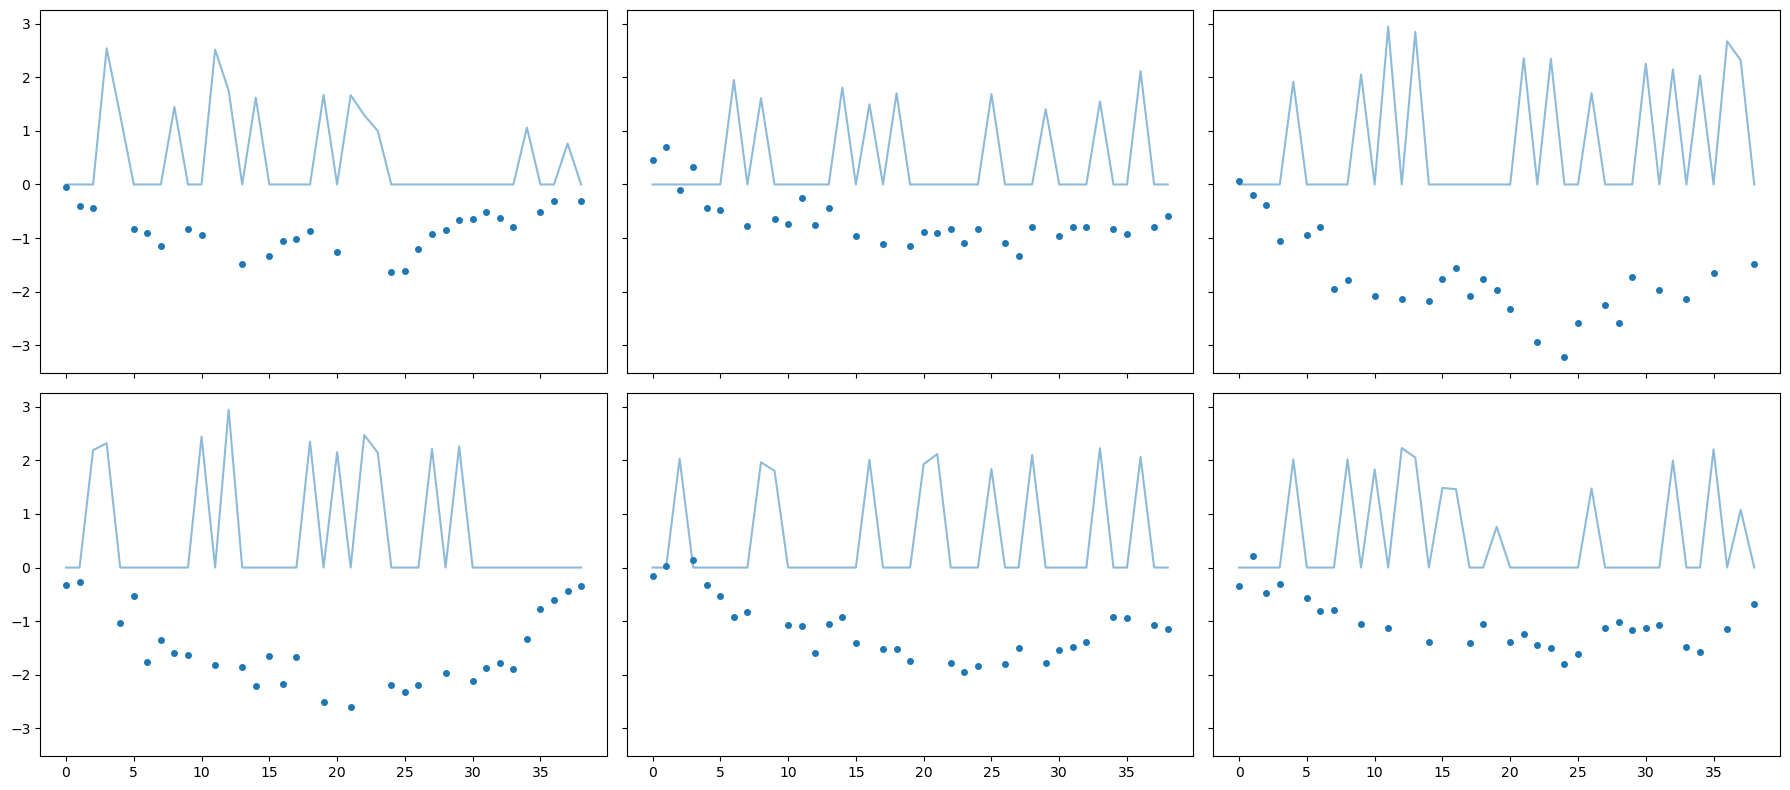

In [43]:
#| hide
learn.MVP.show_preds(sharey=True, nrows=2) # error with nrows=1 or ncols=1

## Save artifact to W&B
> Remove extra information and saving the learner object as an weight and biases artifact

In [44]:
#| hide
# Remove the ShowGraphCallback2 callback to avoid errors in the frontend (TODO)
if show_plots: 
    learn.remove_cb(sgc)
    print("SGC callback removed")

In [45]:
#| export
# Log the learner without the datasets
aux_learn = learn.export_and_get()
if config.use_wandb: 
    run.log_artifact(
        ReferenceArtifact(
            aux_learn, 
            f'mvp', 
            type='learner', 
            metadata=dict(run.config)
        ), 
        aliases=config.alias
    )

## Close W&B

In [46]:
#| export
if print_flag: print("Artifact logged | About to finish run")
run.finish()

Artifact logged | About to finish run


epoch,55
eps_0,1e-05
eps_1,1e-05
lr_0,0.00079
lr_1,0.00079
mom_0,0.88405
mom_1,0.88405
raw_loss,0.19393
sqr_mom_0,0.99
sqr_mom_1,0.99
train_loss,0.19344


In [47]:
#| export
if print_flag: print("Execution ended")
from dvats.imports import beep
beep(1)

Execution ended


In [48]:
#| hide
if reset_kernel:
    import os
    os._exit(00)